In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os

import xarray
from scipy.signal import sweep_poly

from hdpgpc.get_data import compute_estimators_LDS
import math
from scipy.fft import fft
import h5py
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import wavespectra as wv
import xarray as xr
import importlib
import pickle
import hdpgpc.GPI_HDP as hdpgp
import re
from datetime import datetime, timedelta
import time

/home/adrian.perez/Documents/OceanWave/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from hdpgpc.util_plots import print_results
import hdpgpc.util_plots as up
importlib.reload(up)
from hdpgpc.buoy_utils import interpolate_spectral_coefficients

/home/adrian.perez/Documents/OceanWave/HDP-GPC/hdpgpc/hdpgpc/buoy_utils.py:1515: UserWarning:

Numba not available. Install with: pip install numba



---

### 1. Lectura de datos

In [3]:
cwd = os.path.dirname(os.getcwd())
data_path = os.path.join(cwd, 'data', 'ocean', 'wawaves')
f_hillary = h5py.File(os.path.join(data_path, 'Hillarys_202407.mat'),'r')
f_hillary_2 = h5py.File(os.path.join(data_path, 'Hillarys_202408.mat'),'r')
#f = h5py.File(os.path.join(data_path, 'TIDE_SouthAfricaDrifting03_202406.mat'),'r')
print(f_hillary.get('SpotData').keys())
direction = np.concatenate([np.array(f_hillary.get('SpotData/direction')), np.array(f_hillary_2.get('SpotData/direction'))], axis=1)
variance_density = np.concatenate([np.array(f_hillary.get('SpotData/varianceDensity')), np.array(f_hillary_2.get('SpotData/varianceDensity'))], axis=1)
spec_time_hillarys = np.concatenate([np.array(f_hillary.get('SpotData/spec_time')), np.array(f_hillary_2.get('SpotData/spec_time'))], axis=1)
time_hillarys = np.concatenate([np.array(f_hillary.get('SpotData/time')), np.array(f_hillary_2.get('SpotData/time'))], axis=1)
frequency_hillarys = np.concatenate([np.array(f_hillary.get('SpotData/frequency')), np.array(f_hillary_2.get('SpotData/frequency'))], axis=1)
dm_h = np.concatenate([np.array(f_hillary.get('SpotData/dm')), np.array(f_hillary_2.get('SpotData/dm'))], axis=1)
a1 = np.concatenate([np.array(f_hillary.get('SpotData/a1')), np.array(f_hillary_2.get('SpotData/a1'))], axis=1)
a2 = np.concatenate([np.array(f_hillary.get('SpotData/a2')), np.array(f_hillary_2.get('SpotData/a2'))], axis=1)
b1 = np.concatenate([np.array(f_hillary.get('SpotData/b1')), np.array(f_hillary_2.get('SpotData/b1'))], axis=1)
b2 = np.concatenate([np.array(f_hillary.get('SpotData/b2')), np.array(f_hillary_2.get('SpotData/b2'))], axis=1)

print(variance_density.shape)
print(direction.shape)
print(a1.shape)
print(np.array(f_hillary.get('SpotData/dmspr')).shape)



<KeysViewHDF5 ['a1', 'a2', 'b1', 'b2', 'bott_temp', 'df', 'direction', 'directionalSpread', 'dm', 'dm_sea', 'dm_swell', 'dmspr', 'dmspr_sea', 'dmspr_swell', 'dp', 'dpspr', 'endFreq_sea', 'endFreq_swell', 'frequency', 'hsig', 'hsig_sea', 'hsig_swell', 'lat', 'lon', 'name', 'part_time', 'press_std_time', 'press_time', 'pressure', 'pressure_std', 'qf_bott_temp', 'qf_sst', 'qf_waves', 'serialID', 'spec_time', 'startFreq_sea', 'startFreq_swell', 'surf_temp', 'temp_time', 'time', 'tm', 'tm_sea', 'tm_swell', 'tp', 'varianceDensity', 'wind_dir', 'wind_seasurfaceId', 'wind_speed', 'wind_time']>
(79, 2936)
(79, 2936)
(79, 2936)
(1, 744)


In [4]:
startFreq_sea = np.array(f_hillary.get('SpotData/startFreq_sea'))[0][0]
startFreq_swell = np.array(f_hillary.get('SpotData/startFreq_swell'))[0][0]
print(frequency_hillarys.shape)

(79, 2936)


In [5]:
print("Shape of the data: ")
print(variance_density.shape)
num_obs_per_sample, num_samples  = variance_density.shape

Shape of the data: 
(79, 2936)


In [6]:

data = variance_density.T[:,:,np.newaxis]
print(np.sum(data, axis=2).shape)
freq = np.array(frequency_hillarys[:,0])
freq_hillarys = freq
freq_ = np.array(freq)

(2936, 79)


(79, 1)
Shape of hs: (2936, 1)
How much spectra falls in the range 0.5-1.5 Hs: 2936


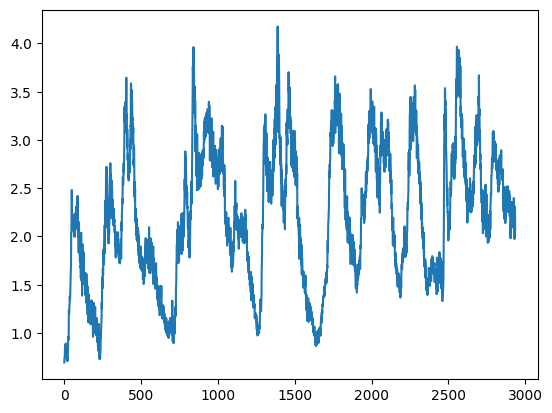

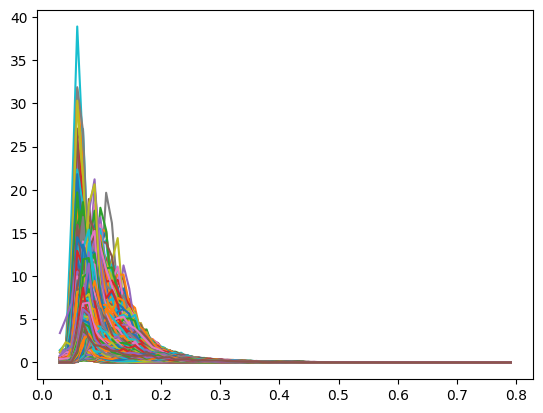

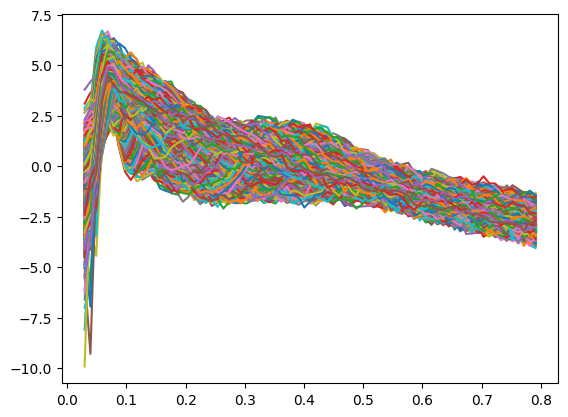

In [7]:
 #Here we are going to compute the Heighs and try to filter following Hamiltons rule.
interv = np.repeat(freq_[1]-freq_[0], num_obs_per_sample)[:, np.newaxis]
print(interv.shape)
hs_h = 4 * np.sqrt(np.sum(data, axis=2) @ interv)
print("Shape of hs: "+str(hs_h.shape))
plt.plot(hs_h)
chosen_indexes = np.where((hs_h > 0.5) & (hs_h < 1.5))[0]
chosen_indexes = np.arange(num_samples)
print("How much spectra falls in the range 0.5-1.5 Hs: " + str(chosen_indexes.shape[0]))
plt.show()
plt.plot(freq, data[:,:,0][chosen_indexes].T)
plt.show()
lognorm_data = np.log(data + 1e-6) - np.mean(np.log(data+ 1e-6), axis=1)[:,np.newaxis,:]
plt.plot(freq, lognorm_data[:,:,0][chosen_indexes].T)
plt.show()


### Se cogen solo los datos de un año natural

In [8]:
#Select indexes
data = data[chosen_indexes]
print("Shape of the data: ")
print(data.shape)

num_samples, num_obs_per_sample, num_outputs = data.shape

Shape of the data: 
(2936, 79, 1)


In [9]:
lim_freq = startFreq_sea
index_freq = np.where(freq>lim_freq)[0][0]+1
std, std_dif, bound_sigma, bound_gamma = compute_estimators_LDS(data, n_f=50, dim=0)
#Seem like these estimators are so big for this data, let's reduce them
std = std * 0.5
std_dif = std_dif * 0.48
bound_sigma = (std * 1e-7, std * 1e-6)
bound_gamma = (std_dif * 1e-9, std_dif * 1e-8)

print("Final sigma:", std)
print("Final gamma:", std_dif)
print("Final sigma bound:", bound_sigma)
print("Final gamma bound:", bound_gamma)

M = 2
sigma = [std * 1.0] * M
gamma = [std_dif * 1.0] * M
outputscale_ = 0.1
ini_lengthscale = 1e-3
bound_lengthscale = (1e-7, 5e-3)
samples = [0, num_obs_per_sample]
l, L = samples[0], samples[1]
# x_basis has to have the same dimension structure as data[0], in this case (171,1) but it could be (n_inducing_points, 1).
lim_freq = startFreq_sea
index_freq = np.where(freq>lim_freq)[0][0]+1
x_basis = np.atleast_2d(freq).T
x_train = np.atleast_2d(freq).T
print(x_train.shape)
#If x_basis is wanted to be smaller than the observations length, then the inducing points approach can be applied setting this parameter to True.
inducing_points = False
#Choose if warp is going to be applied. (In the most recent version is optimized to work with online inference, but it can be used in offline as an additional step at the end of the clustering).
warp = False
#Warp priors
noise_warp = std * 0.1
bound_noise_warp = (noise_warp * 0.1, noise_warp * 0.2)
#Warp time indexes
x_basis_warp = np.atleast_2d(np.arange(freq[0], freq[-1], freq.shape[0] / 2.0, dtype=np.float64)).T

Sigma estimated: 0.08105091650973478
Gamma estimated: 0.08105091650973478
Final sigma: 0.04052545825486739
Final gamma: 0.03890443992467269
Final sigma bound: (4.052545825486739e-09, 4.052545825486739e-08)
Final gamma bound: (np.float64(3.8904439924672694e-11), np.float64(3.8904439924672693e-10))
(79, 1)


In [10]:
sw_gp_hillary = hdpgp.GPI_HDP(x_basis=x_basis, x_basis_warp=x_basis_warp, n_outputs=1,
                          ini_lengthscale=ini_lengthscale, bound_lengthscale=bound_lengthscale,
                          ini_gamma=gamma, ini_sigma=sigma, ini_outputscale=outputscale_, noise_warp=noise_warp,
                          bound_sigma=bound_sigma, bound_gamma=bound_gamma, bound_noise_warp=bound_noise_warp,
                          verbose=False, max_models=100, inducing_points=inducing_points, reestimate_initial_params=False,
                          n_explore_steps=15, free_deg_MNIV=8, share_gp=True, use_snr=False, reduce_outputs=False)

cluster_labels_h = np.load('/home/adrian.perez/Documents/OceanWave/HDP-GPC/hdpgpc/ocean/cluster_labels/resampled_low_freq/cluster_labels_hillary_202407_dynamic.npy')
# ------ Cluster grouping on dynamic_3 ------
# cluster_labels_h[np.where(cluster_labels_h == 1)] = 0
# #cluster_labels_h[np.where(cluster_labels_h == 5)] = 0
# cluster_labels_h[np.where(cluster_labels_h == 2)] = 1
# cluster_labels_h[np.where(cluster_labels_h == 3)] = 2
# cluster_labels_h[np.where(cluster_labels_h == 4)] = 3
# cluster_labels_h[np.where(cluster_labels_h == 6)] = 4
#
# #After-transformations
# cluster_labels_h[np.where(cluster_labels_h == 4)] = 3
# cluster_labels_h[np.where(cluster_labels_h == 5)] = 4

# ------ Cluster grouping on dynamic ------
# cluster_labels_h[np.where(cluster_labels_h == 3)] = 0
# cluster_labels_h[np.where(cluster_labels_h == 5)] = 0
# cluster_labels_h[np.where(cluster_labels_h == 6)] = 0
# cluster_labels_h[np.where(cluster_labels_h == 7)] = 0
#
# cluster_labels_h[np.where(cluster_labels_h == 4)] = 3
# cluster_labels_h[np.where(cluster_labels_h == 8)] = 4
# cluster_labels_h[np.where(cluster_labels_h == 9)] = 5
#
# #After transform
# cluster_labels_h[np.where(cluster_labels_h == 3)] = 2
# cluster_labels_h[np.where(cluster_labels_h == 4)] = 2
# cluster_labels_h[np.where(cluster_labels_h == 5)] = 2

# ------ Cluster grouping on dynamic 4 ------

# cluster_labels_h[np.where(cluster_labels_h == 2)] = 1
M = np.unique(cluster_labels_h).shape[0]
num_samples = data.shape[0]
#logdata = np.log(data + 1e-6)
x_trains = np.array([x_train] * num_samples)
sw_gp_hillary.reload_model_from_labels(x_trains, data, cluster_labels_h, M)

/home/adrian.perez/Documents/OceanWave/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:129: UserWarning:

CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)



---Kernel estimated---
1.61**2 * RBF(length_scale=0.0156) + WhiteKernel(noise_level=3.77e-08)
Group responsability estimated: [635 572 528 315 282 276 120  96  82  30]
Sum resp_temp: [635 572 528 315 282 276 120  96  82  30]
Q_em: -258685.20, Q_lat: -295172.19, Elbo_linear: -1351.23, Elbo_LDS: -4323.16

-------ELBO:tensor([-559531.7739])-------


In [11]:
sw_gp_hillary.gpmodels[0][0].x_train[0].shape

torch.Size([79, 1])

Model 1 : MainModel: N : [N-635]
Model 2 : MainModel: N : [N-572]
Model 3 : MainModel: N : [N-528]
Model 4 : MainModel: N : [N-315]
Model 5 : MainModel: N : [N-282]
Model 6 : MainModel: N : [N-276]
Model 7 : MainModel: N : [N-120]
Model 8 : MainModel: N : [N-96]
Model 9 : MainModel: N : [N-82]
Model 10 : MainModel: N : [N-30]
Classification error: 0 / 2936 -- 0.00000


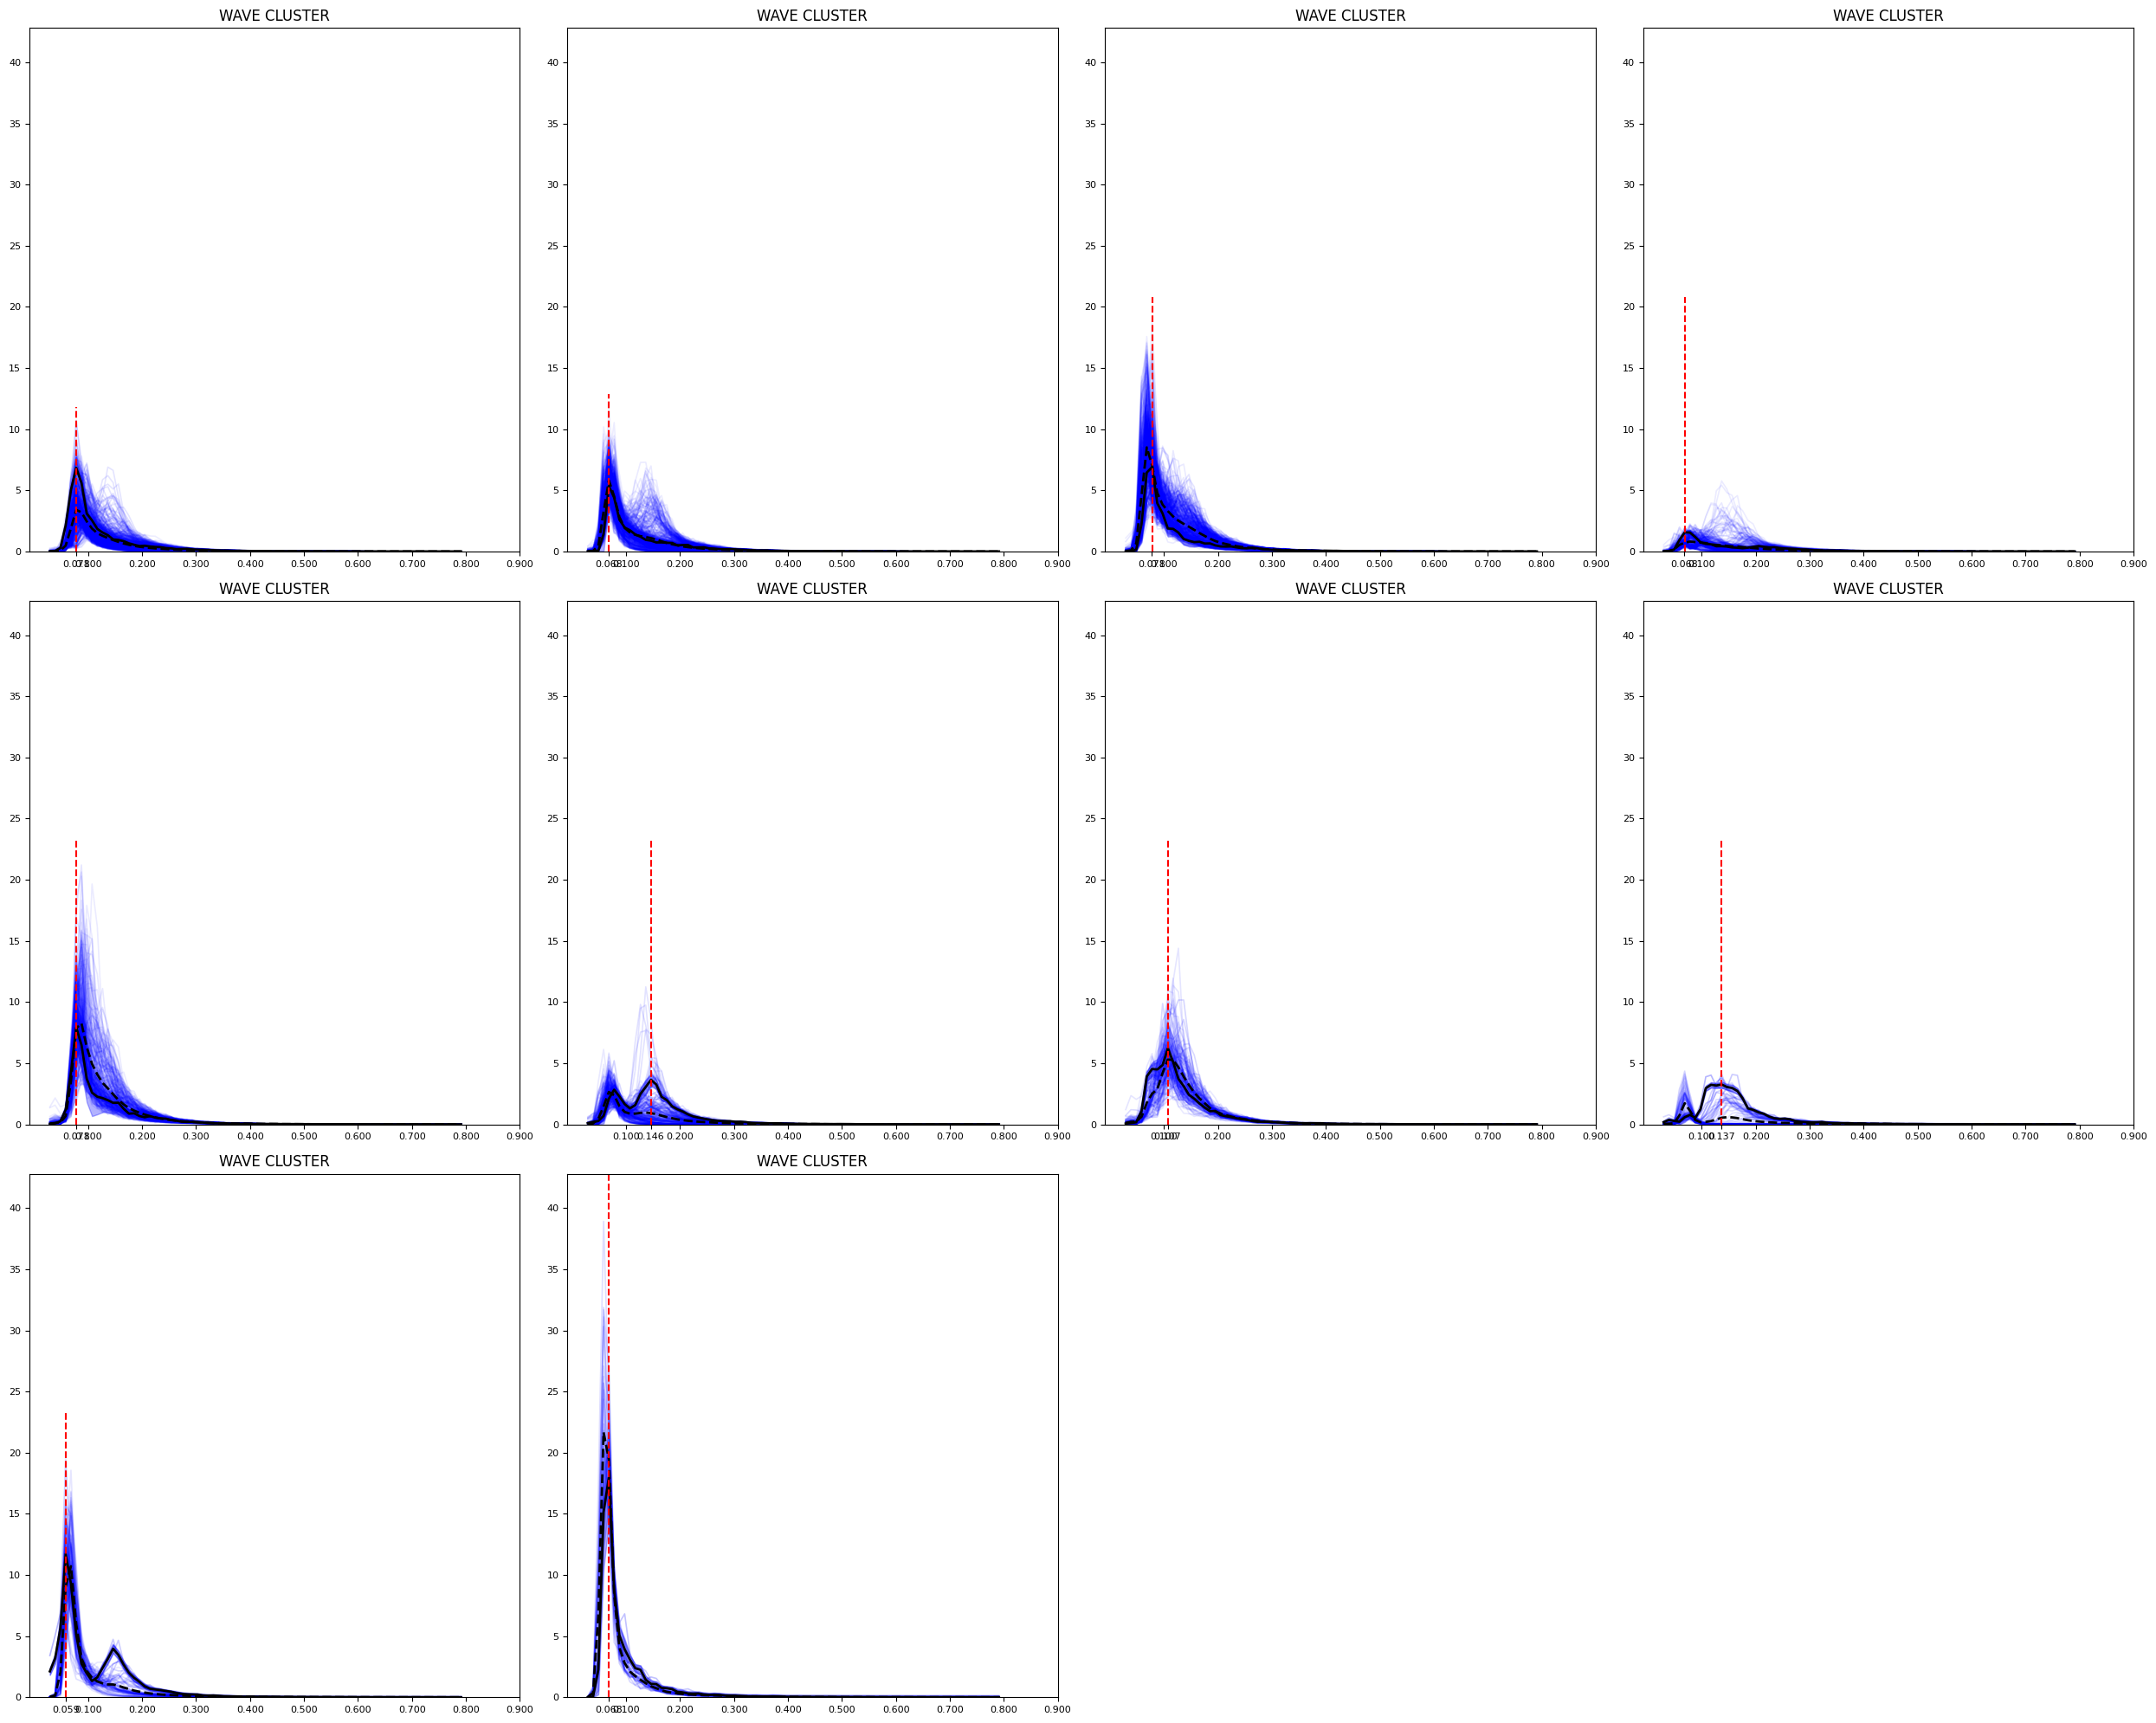

In [12]:
labels = np.array(['N'] * 6500)
main_model = print_results(sw_gp_hillary, labels, 0, error=False)
selected_gpmodels = sw_gp_hillary.selected_gpmodels()
up.plot_models_plotly(sw_gp_hillary, selected_gpmodels, main_model, labels, N_0=0, lead=0, step=(freq[1]-freq[0])/1,
                   plot_latent=False, title='WAVE CLUSTER',ticks=True, yscale=True, save="/home/adrian.perez/Documents/OceanWave/HDP-GPC/hdpgpc/ocean/clusters_hillary.png", line_max=True)

Now with drifting 03.

In [13]:

cwd = os.path.dirname(os.getcwd())
data_path = os.path.join(cwd, 'data', 'ocean', 'wawaves')
#f = h5py.File(os.path.join(data_path, 'Hillarys_202405.mat'), 'r')
f_drift03 = h5py.File(os.path.join(data_path, 'TIDE_SouthAfricaDrifting03_202407.mat'),'r')
f_drift03_2 = h5py.File(os.path.join(data_path, 'TIDE_SouthAfricaDrifting03_202408.mat'),'r')
print(f_drift03.get('SpotData').keys())
direction = np.concatenate([np.array(f_drift03.get('SpotData/direction')), np.array(f_drift03_2.get('SpotData/direction'))], axis=1)
variance_density = np.concatenate([np.array(f_drift03.get('SpotData/varianceDensity')), np.array(f_drift03_2.get('SpotData/varianceDensity'))], axis=1)
spec_time_drift03 = np.concatenate([np.array(f_drift03.get('SpotData/spec_time')), np.array(f_drift03_2.get('SpotData/spec_time'))], axis=1)
time_drift03 = np.concatenate([np.array(f_drift03.get('SpotData/time')), np.array(f_drift03_2.get('SpotData/time'))], axis=1)
frequency = np.concatenate([np.array(f_drift03.get('SpotData/frequency')), np.array(f_drift03_2.get('SpotData/frequency'))], axis=1)
dm_d03 = np.concatenate([np.array(f_drift03.get('SpotData/dm')), np.array(f_drift03_2.get('SpotData/dm'))], axis=1)
a1 = np.concatenate([np.array(f_drift03.get('SpotData/a1')), np.array(f_drift03_2.get('SpotData/a1'))], axis=1)
a2 = np.concatenate([np.array(f_drift03.get('SpotData/a2')), np.array(f_drift03_2.get('SpotData/a2'))], axis=1)
b1 = np.concatenate([np.array(f_drift03.get('SpotData/b1')), np.array(f_drift03_2.get('SpotData/b1'))], axis=1)
b2 = np.concatenate([np.array(f_drift03.get('SpotData/b2')), np.array(f_drift03_2.get('SpotData/b2'))], axis=1)
print("Shape of the data: ")
print(variance_density.shape)

# result = interpolate_spectral_coefficients(
#     frequency[:,0],
#     variance_density,
#     a1, b1, a2, b2,
#     n_points=200,
#     enforce_constraints=True
# )
# frequency_drift03_dense = np.array([result['f_dense']]*frequency.shape[1]).T
# S_dense = result['variance_density_dense']
# plt.plot(frequency[:,0],variance_density[:,0])
# plt.plot(frequency_drift03_dense[:,0], S_dense[:,0])
#
# frequency = frequency_drift03_dense
# variance_density = S_dense
# a1, b1, a2, b2 = result['a1_dense'], result['b1_dense'], result['a2_dense'], result['b2_dense']


<KeysViewHDF5 ['a1', 'a2', 'b1', 'b2', 'bott_temp', 'df', 'direction', 'directionalSpread', 'dm', 'dm_sea', 'dm_swell', 'dmspr', 'dmspr_sea', 'dmspr_swell', 'dp', 'dpspr', 'endFreq_sea', 'endFreq_swell', 'frequency', 'hsig', 'hsig_sea', 'hsig_swell', 'lat', 'lon', 'name', 'part_time', 'press_std_time', 'press_time', 'pressure', 'pressure_std', 'qf_bott_temp', 'qf_sst', 'qf_waves', 'serialID', 'spec_time', 'startFreq_sea', 'startFreq_swell', 'surf_temp', 'temp_time', 'time', 'tm', 'tm_sea', 'tm_swell', 'tp', 'varianceDensity', 'wind_dir', 'wind_seasurfaceId', 'wind_speed', 'wind_time']>
Shape of the data: 
(39, 645)


In [14]:


frequency_drift03 = frequency[:, 0]
data_drifting03 = variance_density.T[:,:,np.newaxis]
num_samples, num_obs_per_sample, num_outputs = data_drifting03.shape
freq_ = np.array(frequency_drift03)

(645, 39, 1)
(39, 1)
Shape of hs: (645, 1)
How much spectra falls in the range 0.5-1.5 Hs: 645


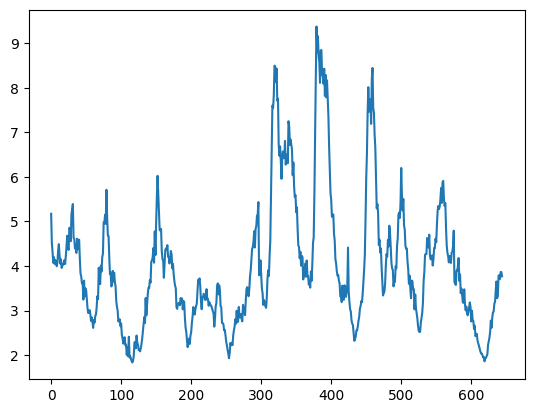

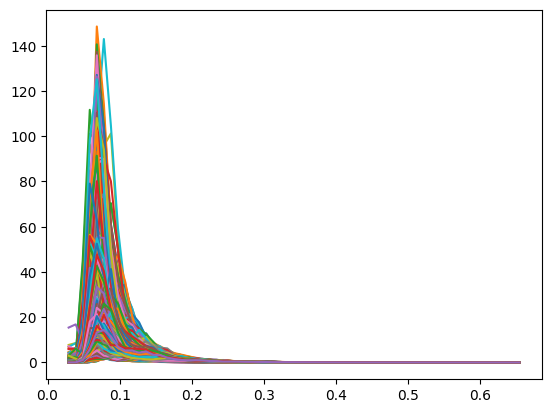

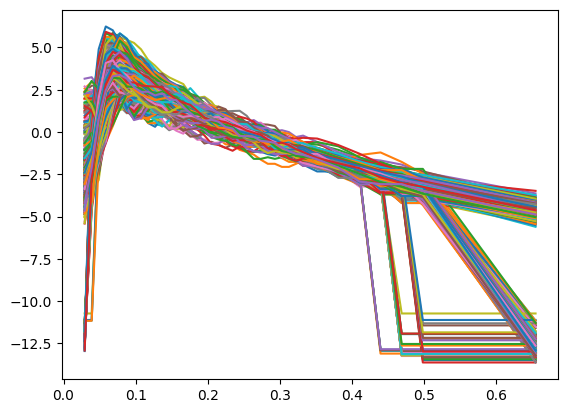

In [15]:
#Here we are going to compute the Heighs and try to filter following Hamiltons rule.
interv = np.repeat(freq_[1] - freq_[0], num_obs_per_sample)[:, np.newaxis]
print(data_drifting03.shape)
print(interv.shape)
hs_d03 = 4 * np.sqrt(np.sum(data_drifting03, axis=2) @ interv)
print("Shape of hs: " + str(hs_d03.shape))
plt.plot(hs_d03)
chosen_indexes = np.where((hs_d03 > 0.5) & (hs_d03 < 1.5))[0]
chosen_indexes = np.arange(num_samples)
print("How much spectra falls in the range 0.5-1.5 Hs: " + str(chosen_indexes.shape[0]))
plt.show()
plt.plot(freq_, data_drifting03[:, :, 0][chosen_indexes].T)
plt.show()
lognorm_data = np.log(data_drifting03 + 1e-6) - np.mean(np.log(data_drifting03 + 1e-6), axis=1)[:, np.newaxis, :]
plt.plot(freq_, lognorm_data[:, :, 0][chosen_indexes].T)
plt.show()

In [16]:
data_drifting03 = data_drifting03[chosen_indexes]
print("Shape of the data: ")
print(data_drifting03.shape)

lim_freq = startFreq_sea
index_freq = np.where(freq_>lim_freq)[0][0]+1
num_samples, num_obs_per_sample, num_outputs = data_drifting03.shape
std, std_dif, bound_sigma, bound_gamma = compute_estimators_LDS(data_drifting03, n_f=50, dim=0)
#Seem like these estimators are so big for this data, let's reduce them
std = std * 1.0
std_dif = std_dif * 0.1
bound_sigma = (std * 1e-7, std * 1e-6)
bound_gamma = (std_dif * 1e-9, std_dif * 1e-8)

print("Final sigma:", std)
print("Final gamma:", std_dif)
print("Final sigma bound:", bound_sigma)
print("Final gamma bound:", bound_gamma)

M = 2
sigma = [std * 1.0] * M
gamma = [std_dif * 1.0] * M
outputscale_ = 0.1
ini_lengthscale = 1e-3
bound_lengthscale = (1e-7, 5e-3)
samples = [0, num_obs_per_sample]
l, L = samples[0], samples[1]
# x_basis has to have the same dimension structure as data[0], in this case (171,1) but it could be (n_inducing_points, 1).
lim_freq = startFreq_sea
index_freq = np.where(freq_>lim_freq)[0][0]+1
x_basis = np.atleast_2d(freq_).T
x_train = np.atleast_2d(freq_).T
print(x_train.shape)
#If x_basis is wanted to be smaller than the observations length, then the inducing points approach can be applied setting this parameter to True.
inducing_points = False
#Choose if warp is going to be applied. (In the most recent version is optimized to work with online inference, but it can be used in offline as an additional step at the end of the clustering).
warp = False
#Warp priors
noise_warp = std * 0.1
bound_noise_warp = (noise_warp * 0.1, noise_warp * 0.2)
#Warp time indexes
x_basis_warp = np.atleast_2d(np.arange(freq_[0], freq_[-1], freq_.shape[0] / 2.0, dtype=np.float64)).T

Shape of the data: 
(645, 39, 1)
Sigma estimated: 0.10303838996822784
Gamma estimated: 0.10303838996822784
Final sigma: 0.10303838996822784
Final gamma: 0.010303838996822785
Final sigma bound: (1.0303838996822784e-08, 1.0303838996822783e-07)
Final gamma bound: (np.float64(1.0303838996822785e-11), np.float64(1.0303838996822785e-10))
(39, 1)


In [17]:
sw_gp_drift03 = hdpgp.GPI_HDP(x_basis=x_basis, x_basis_warp=x_basis_warp, n_outputs=1,
                          ini_lengthscale=ini_lengthscale, bound_lengthscale=bound_lengthscale,
                          ini_gamma=gamma, ini_sigma=sigma, ini_outputscale=outputscale_, noise_warp=noise_warp,
                          bound_sigma=bound_sigma, bound_gamma=bound_gamma, bound_noise_warp=bound_noise_warp,
                          verbose=False, max_models=100, inducing_points=inducing_points, reestimate_initial_params=False,
                          n_explore_steps=15, free_deg_MNIV=8, share_gp=True, use_snr=False, reduce_outputs=False)

cluster_labels_d03 = np.load('/home/adrian.perez/Documents/OceanWave/HDP-GPC/hdpgpc/ocean/cluster_labels/resampled_low_freq/cluster_labels_drift03_202407_dynamic_2.npy')
# ------ Cluster grouping on dynamic 2 ------
# cluster_labels_d03[np.where(cluster_labels_d03 == 1)] = 0
# cluster_labels_d03[np.where(cluster_labels_d03 == 2)] = 0
# cluster_labels_d03[np.where(cluster_labels_d03 == 4)] = 0
#
# cluster_labels_d03[np.where(cluster_labels_d03 == 7)] = 5
# #cluster_labels_d03[np.where(cluster_labels_d03 == 8)] = 5
#
# cluster_labels_d03[np.where(cluster_labels_d03 == 3)] = 1
# cluster_labels_d03[np.where(cluster_labels_d03 == 5)] = 2
# cluster_labels_d03[np.where(cluster_labels_d03 == 6)] = 3
# cluster_labels_d03[np.where(cluster_labels_d03 == 8)] = 4
#
# #After-transformations
# cluster_labels_d03[np.where(cluster_labels_d03 == 2)] = 1
# cluster_labels_d03[np.where(cluster_labels_d03 == 3)] = 1
# cluster_labels_d03[np.where(cluster_labels_d03 == 4)] = 1
# cluster_labels_d03[np.where(cluster_labels_d03 == 5)] = 1

# ------ Cluster grouping on dynamic 4 ------

M = np.unique(cluster_labels_d03).shape[0]
num_samples = data_drifting03.shape[0]
#logdata = np.log(data + 1e-6)
x_trains = np.array([x_train] * num_samples)
sw_gp_drift03.reload_model_from_labels(x_trains, data_drifting03, cluster_labels_d03, M)

---Kernel estimated---
1.58**2 * RBF(length_scale=0.0167) + WhiteKernel(noise_level=9.62e-08)
Group responsability estimated: [181 144 141  69  62  25  20   1   2]
Sum resp_temp: [181 144 141  69  62  25  20   1   2]
Q_em: -32443.59, Q_lat: -132995.94, Elbo_linear: -484.56, Elbo_LDS: -555.56

-------ELBO:tensor([-166479.6558])-------


Model 1 : MainModel: N : [N-181]
Model 2 : MainModel: N : [N-144]
Model 3 : MainModel: N : [N-141]
Model 4 : MainModel: N : [N-69]
Model 5 : MainModel: N : [N-62]
Model 6 : MainModel: N : [N-25]
Model 7 : MainModel: N : [N-20]
Model 8 : MainModel: N : [N-1]
Model 9 : MainModel: N : [N-2]
Classification error: 0 / 645 -- 0.00000


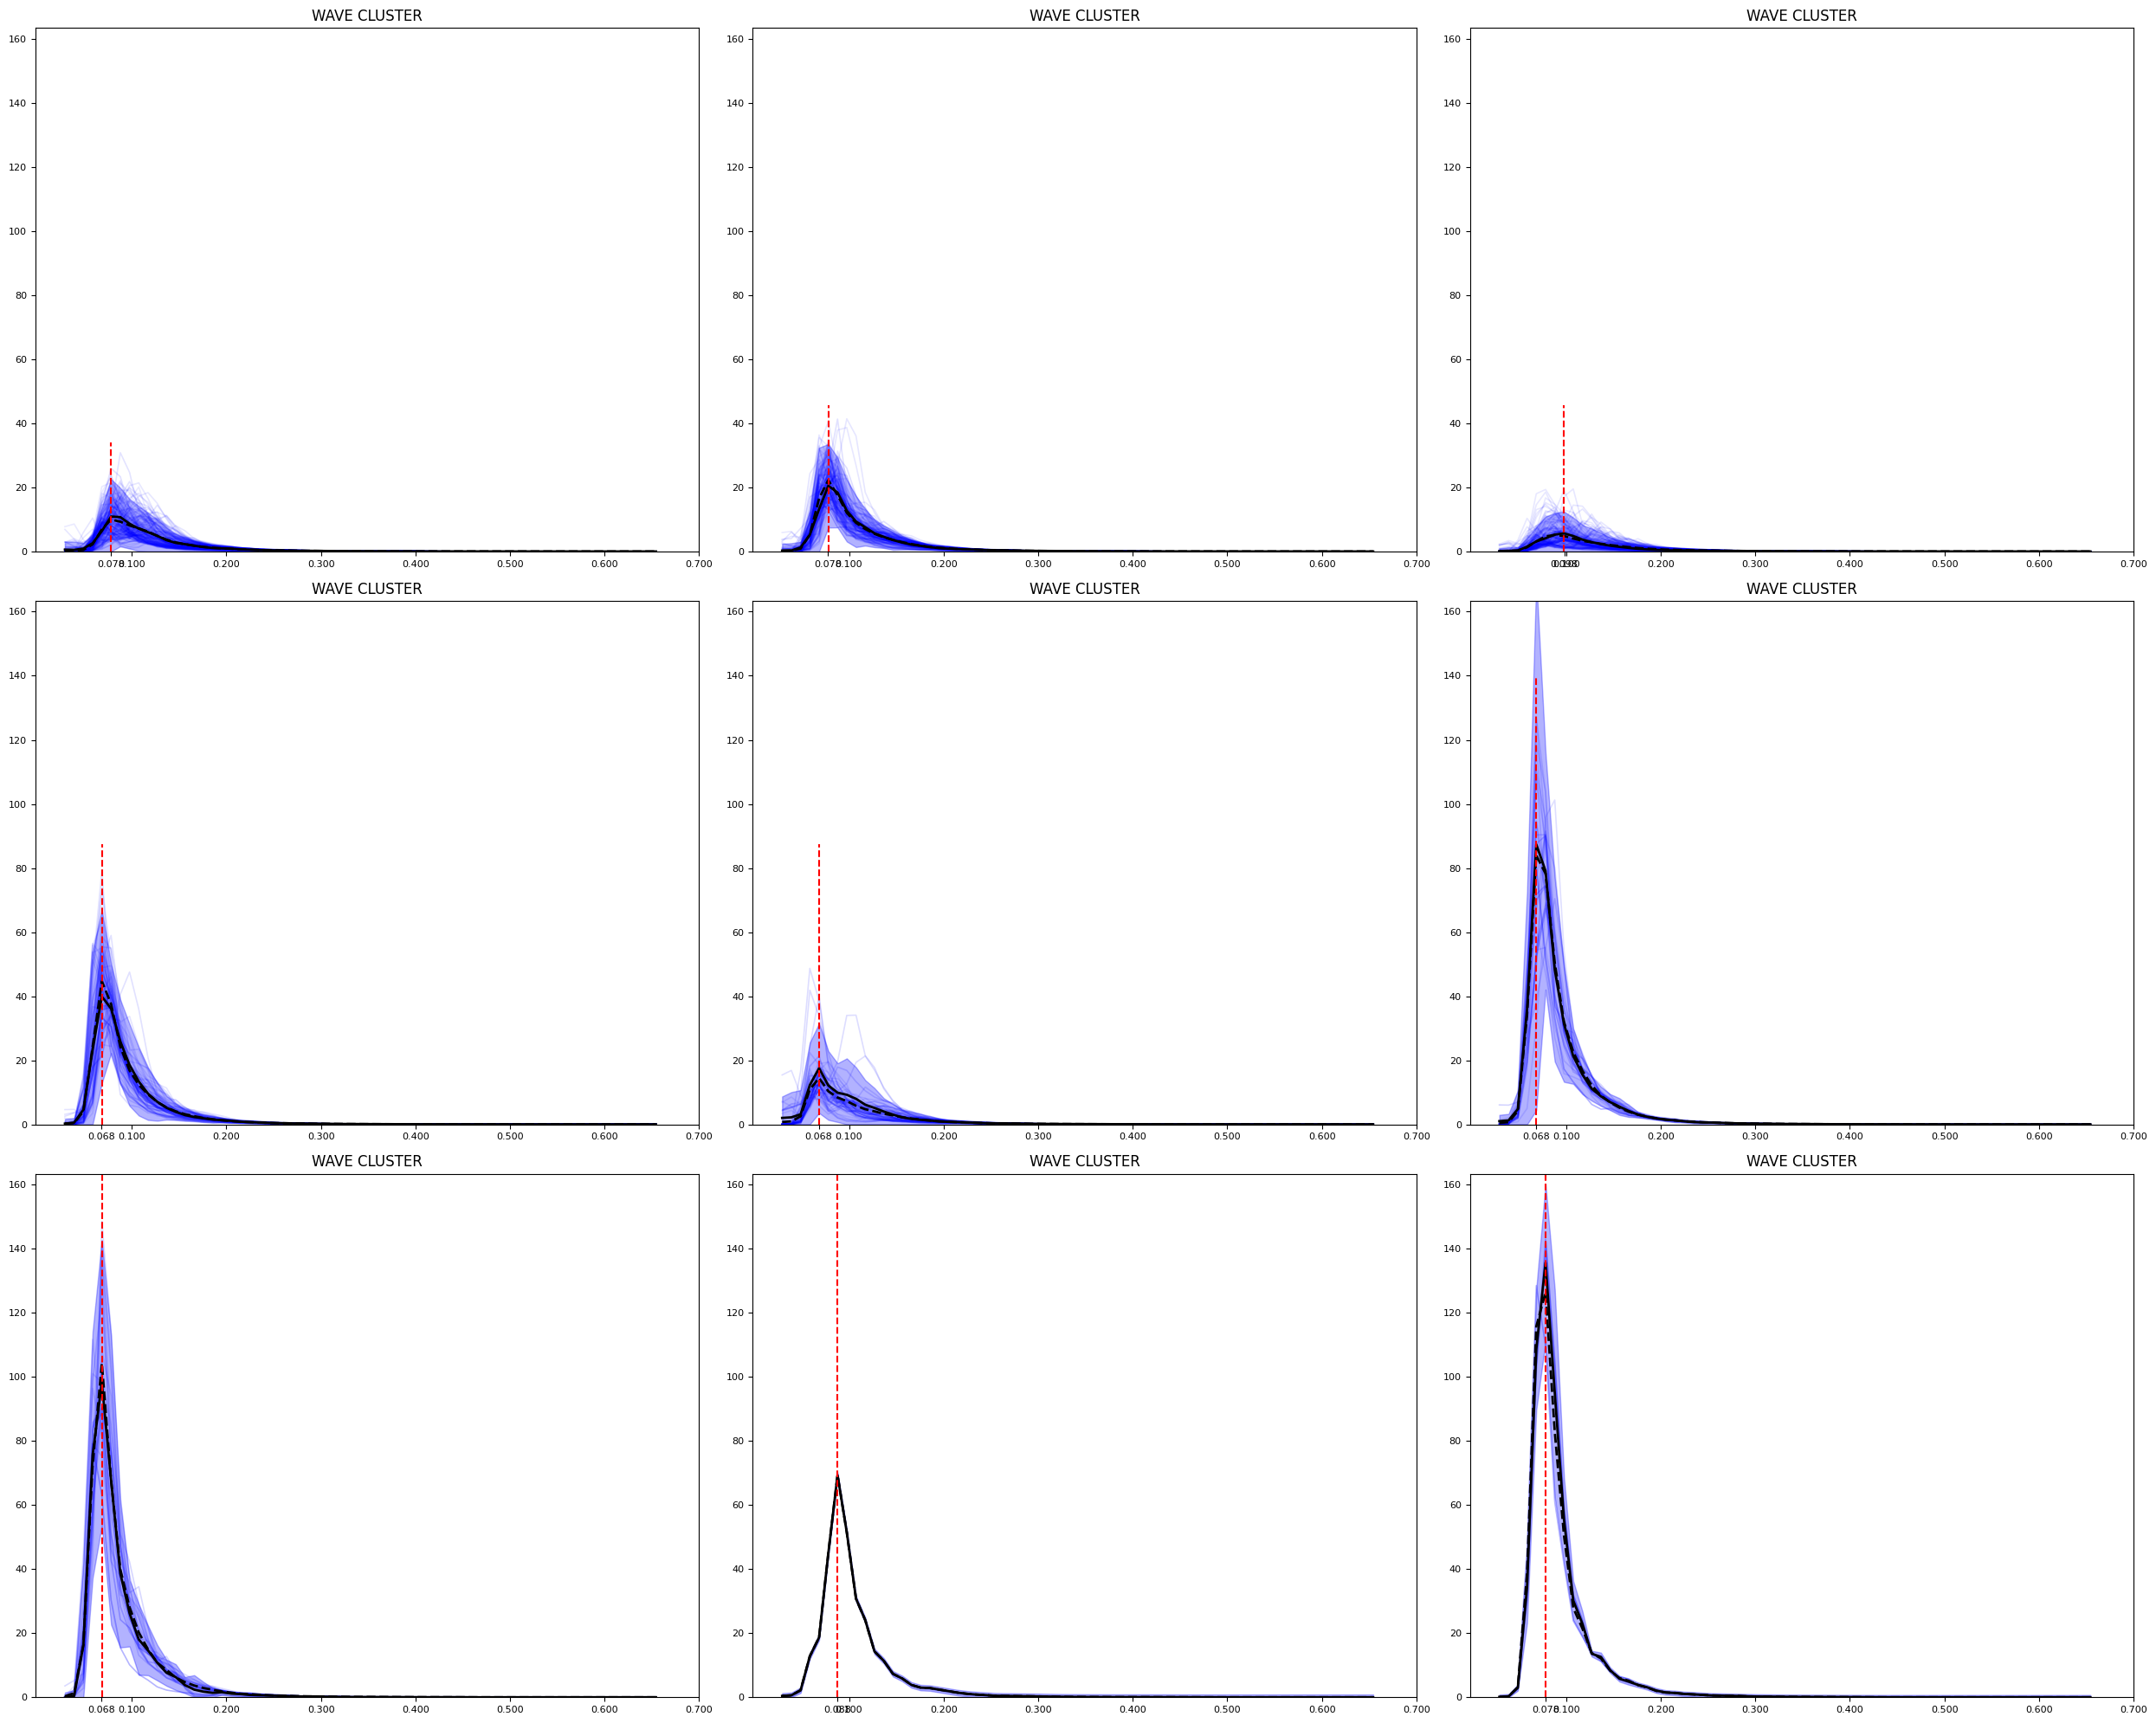

In [18]:
labels = np.array(['N'] * 6500)
main_model = print_results(sw_gp_drift03, labels, 0, error=False)
selected_gpmodels = sw_gp_drift03.selected_gpmodels()
up.plot_models_plotly(sw_gp_drift03, selected_gpmodels, main_model, labels, N_0=0, lead=0, step=(freq_[1]-freq_[0])/1,
                   plot_latent=False, title='WAVE CLUSTER',ticks=True, yscale=True, save="/home/adrian.perez/Documents/OceanWave/HDP-GPC/hdpgpc/ocean/clusters_drift03.png", line_max=True)

Now with drifting 06.

In [19]:

cwd = os.path.dirname(os.getcwd())
data_path = os.path.join(cwd, 'data', 'ocean', 'wawaves')
#f = h5py.File(os.path.join(data_path, 'Hillarys_202405.mat'), 'r')
f_drift06 = h5py.File(os.path.join(data_path, 'TIDE_SouthAfricaDrifting08_202407.mat'), 'r')
f_drift06_2 = h5py.File(os.path.join(data_path, 'TIDE_SouthAfricaDrifting08_202408.mat'), 'r')
print(f_drift06.get('SpotData').keys())
direction = np.concatenate([np.array(f_drift06.get('SpotData/direction')), np.array(f_drift06_2.get('SpotData/direction'))], axis=1)
variance_density = np.concatenate([np.array(f_drift06.get('SpotData/varianceDensity')), np.array(f_drift06_2.get('SpotData/varianceDensity'))], axis=1)
spec_time_drift06 = np.concatenate([np.array(f_drift06.get('SpotData/spec_time')), np.array(f_drift06_2.get('SpotData/spec_time'))], axis=1)
time_drift06 = np.concatenate([np.array(f_drift06.get('SpotData/time')), np.array(f_drift06_2.get('SpotData/time'))], axis=1)
frequency = np.concatenate([np.array(f_drift06.get('SpotData/frequency')), np.array(f_drift06_2.get('SpotData/frequency'))], axis=1)
dm_d06 = np.concatenate([np.array(f_drift06.get('SpotData/dm')), np.array(f_drift06_2.get('SpotData/dm'))], axis=1)
a1 = np.concatenate([np.array(f_drift06.get('SpotData/a1')), np.array(f_drift06_2.get('SpotData/a1'))], axis=1)
a2 = np.concatenate([np.array(f_drift06.get('SpotData/a2')), np.array(f_drift06_2.get('SpotData/a2'))], axis=1)
b1 = np.concatenate([np.array(f_drift06.get('SpotData/b1')), np.array(f_drift06_2.get('SpotData/b1'))], axis=1)
b2 = np.concatenate([np.array(f_drift06.get('SpotData/b2')), np.array(f_drift06_2.get('SpotData/b2'))], axis=1)
print("Shape of the data: ")
print(variance_density.shape)

# result = interpolate_spectral_coefficients(
#     frequency[:,0],
#     variance_density,
#     a1, b1, a2, b2,
#     n_points=200,
#     enforce_constraints=True
# )
# frequency_drift06_dense = np.array([result['f_dense']]*frequency.shape[1]).T
# S_dense = result['variance_density_dense']
# plt.plot(frequency[:,0],variance_density[:,0])
# plt.plot(frequency_drift06_dense[:,0], S_dense[:,0])

# frequency = frequency_drift06_dense
# variance_density = S_dense
# a1, b1, a2, b2 = result['a1_dense'], result['b1_dense'], result['a2_dense'], result['b2_dense']

<KeysViewHDF5 ['a1', 'a2', 'b1', 'b2', 'bott_temp', 'df', 'direction', 'directionalSpread', 'dm', 'dm_sea', 'dm_swell', 'dmspr', 'dmspr_sea', 'dmspr_swell', 'dp', 'dpspr', 'endFreq_sea', 'endFreq_swell', 'frequency', 'hsig', 'hsig_sea', 'hsig_swell', 'lat', 'lon', 'name', 'part_time', 'press_std_time', 'press_time', 'pressure', 'pressure_std', 'qf_bott_temp', 'qf_sst', 'qf_waves', 'serialID', 'spec_time', 'startFreq_sea', 'startFreq_swell', 'surf_temp', 'temp_time', 'time', 'tm', 'tm_sea', 'tm_swell', 'tp', 'varianceDensity', 'wind_dir', 'wind_seasurfaceId', 'wind_speed', 'wind_time']>
Shape of the data: 
(39, 747)


Shape of hs: (747, 1)
How much spectra falls in the range 0.5-1.5 Hs: 747


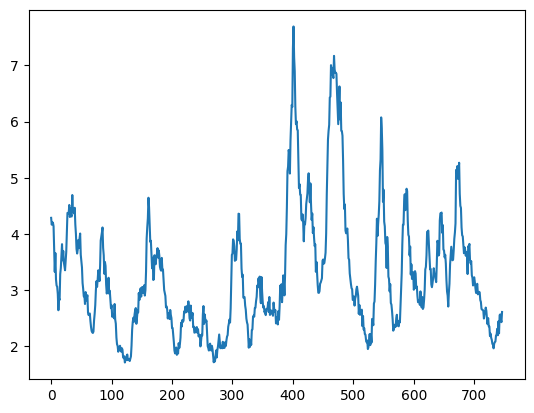

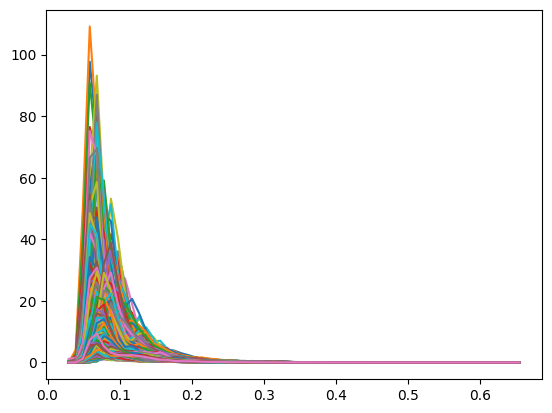

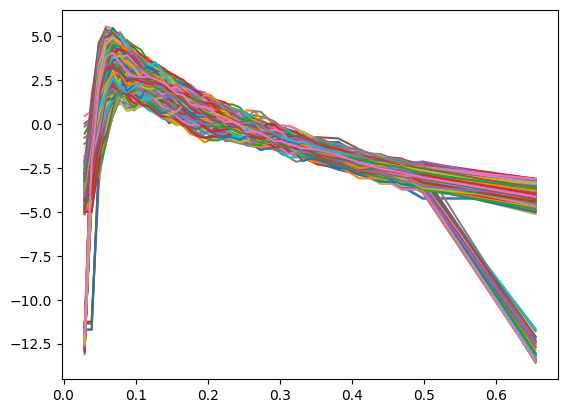

Shape of the data: 
(747, 39, 1)
Sigma estimated: 0.08411358216742469
Gamma estimated: 0.08411358216742469
Final sigma: 0.0021028395541856175
Final gamma: 0.0006729086573393976
Final sigma bound: (2.1028395541856175e-10, 2.1028395541856175e-09)
Final gamma bound: (np.float64(6.729086573393976e-13), np.float64(6.729086573393976e-12))


In [20]:

num_obs_per_sample, num_samples = variance_density.shape
frequency_drift06 = frequency[:, 0]
data_drifting06 = variance_density.T[:,:,np.newaxis]
freq_ = np.array(frequency_drift06)
#Here we are going to compute the Heighs and try to filter following Hamiltons rule.
interv = np.repeat(freq_[1] - freq_[0], num_obs_per_sample)[:, np.newaxis]
hs_d06 = 4 * np.sqrt(np.sum(data_drifting06, axis=2) @ interv)
print("Shape of hs: " + str(hs_d06.shape))
plt.plot(hs_d06)
chosen_indexes = np.where((hs_d06 > 0.5) & (hs_d06 < 1.5))[0]
chosen_indexes = np.arange(num_samples)
print("How much spectra falls in the range 0.5-1.5 Hs: " + str(chosen_indexes.shape[0]))
plt.show()
plt.plot(freq_, data_drifting06[:, :, 0][chosen_indexes].T)
plt.show()
lognorm_data = np.log(data_drifting06 + 1e-6) - np.mean(np.log(data_drifting06 + 1e-6), axis=1)[:, np.newaxis, :]
plt.plot(freq_, lognorm_data[:, :, 0][chosen_indexes].T)
plt.show()
data_drifting06 = data_drifting06[chosen_indexes]
print("Shape of the data: ")
print(data_drifting06.shape)

lim_freq = startFreq_sea
index_freq = np.where(freq_>lim_freq)[0][0]+1
num_samples, num_obs_per_sample, num_outputs = data_drifting06.shape
std, std_dif, bound_sigma, bound_gamma = compute_estimators_LDS(data_drifting06, n_f=50, dim=0)
#Seem like these estimators are so big for this data, let's reduce them
std = std * 0.025
std_dif = std_dif * 0.008
bound_sigma = (std * 1e-7, std * 1e-6)
bound_gamma = (std_dif * 1e-9, std_dif * 1e-8)

print("Final sigma:", std)
print("Final gamma:", std_dif)
print("Final sigma bound:", bound_sigma)
print("Final gamma bound:", bound_gamma)

(39, 1)
---Kernel estimated---
1.63**2 * RBF(length_scale=0.0177) + WhiteKernel(noise_level=1.96e-09)
Group responsability estimated: [505 100  91  29  16   4   2]
Sum resp_temp: [505 100  91  29  16   4   2]
Q_em: -75230.29, Q_lat: -188032.22, Elbo_linear: -347.24, Elbo_LDS: -774.46

-------ELBO:tensor([-264384.2222])-------
Model 1 : MainModel: N : [N-505]
Model 2 : MainModel: N : [N-100]
Model 3 : MainModel: N : [N-91]
Model 4 : MainModel: N : [N-29]
Model 5 : MainModel: N : [N-16]
Model 6 : MainModel: N : [N-4]
Model 7 : MainModel: N : [N-2]
Classification error: 0 / 747 -- 0.00000


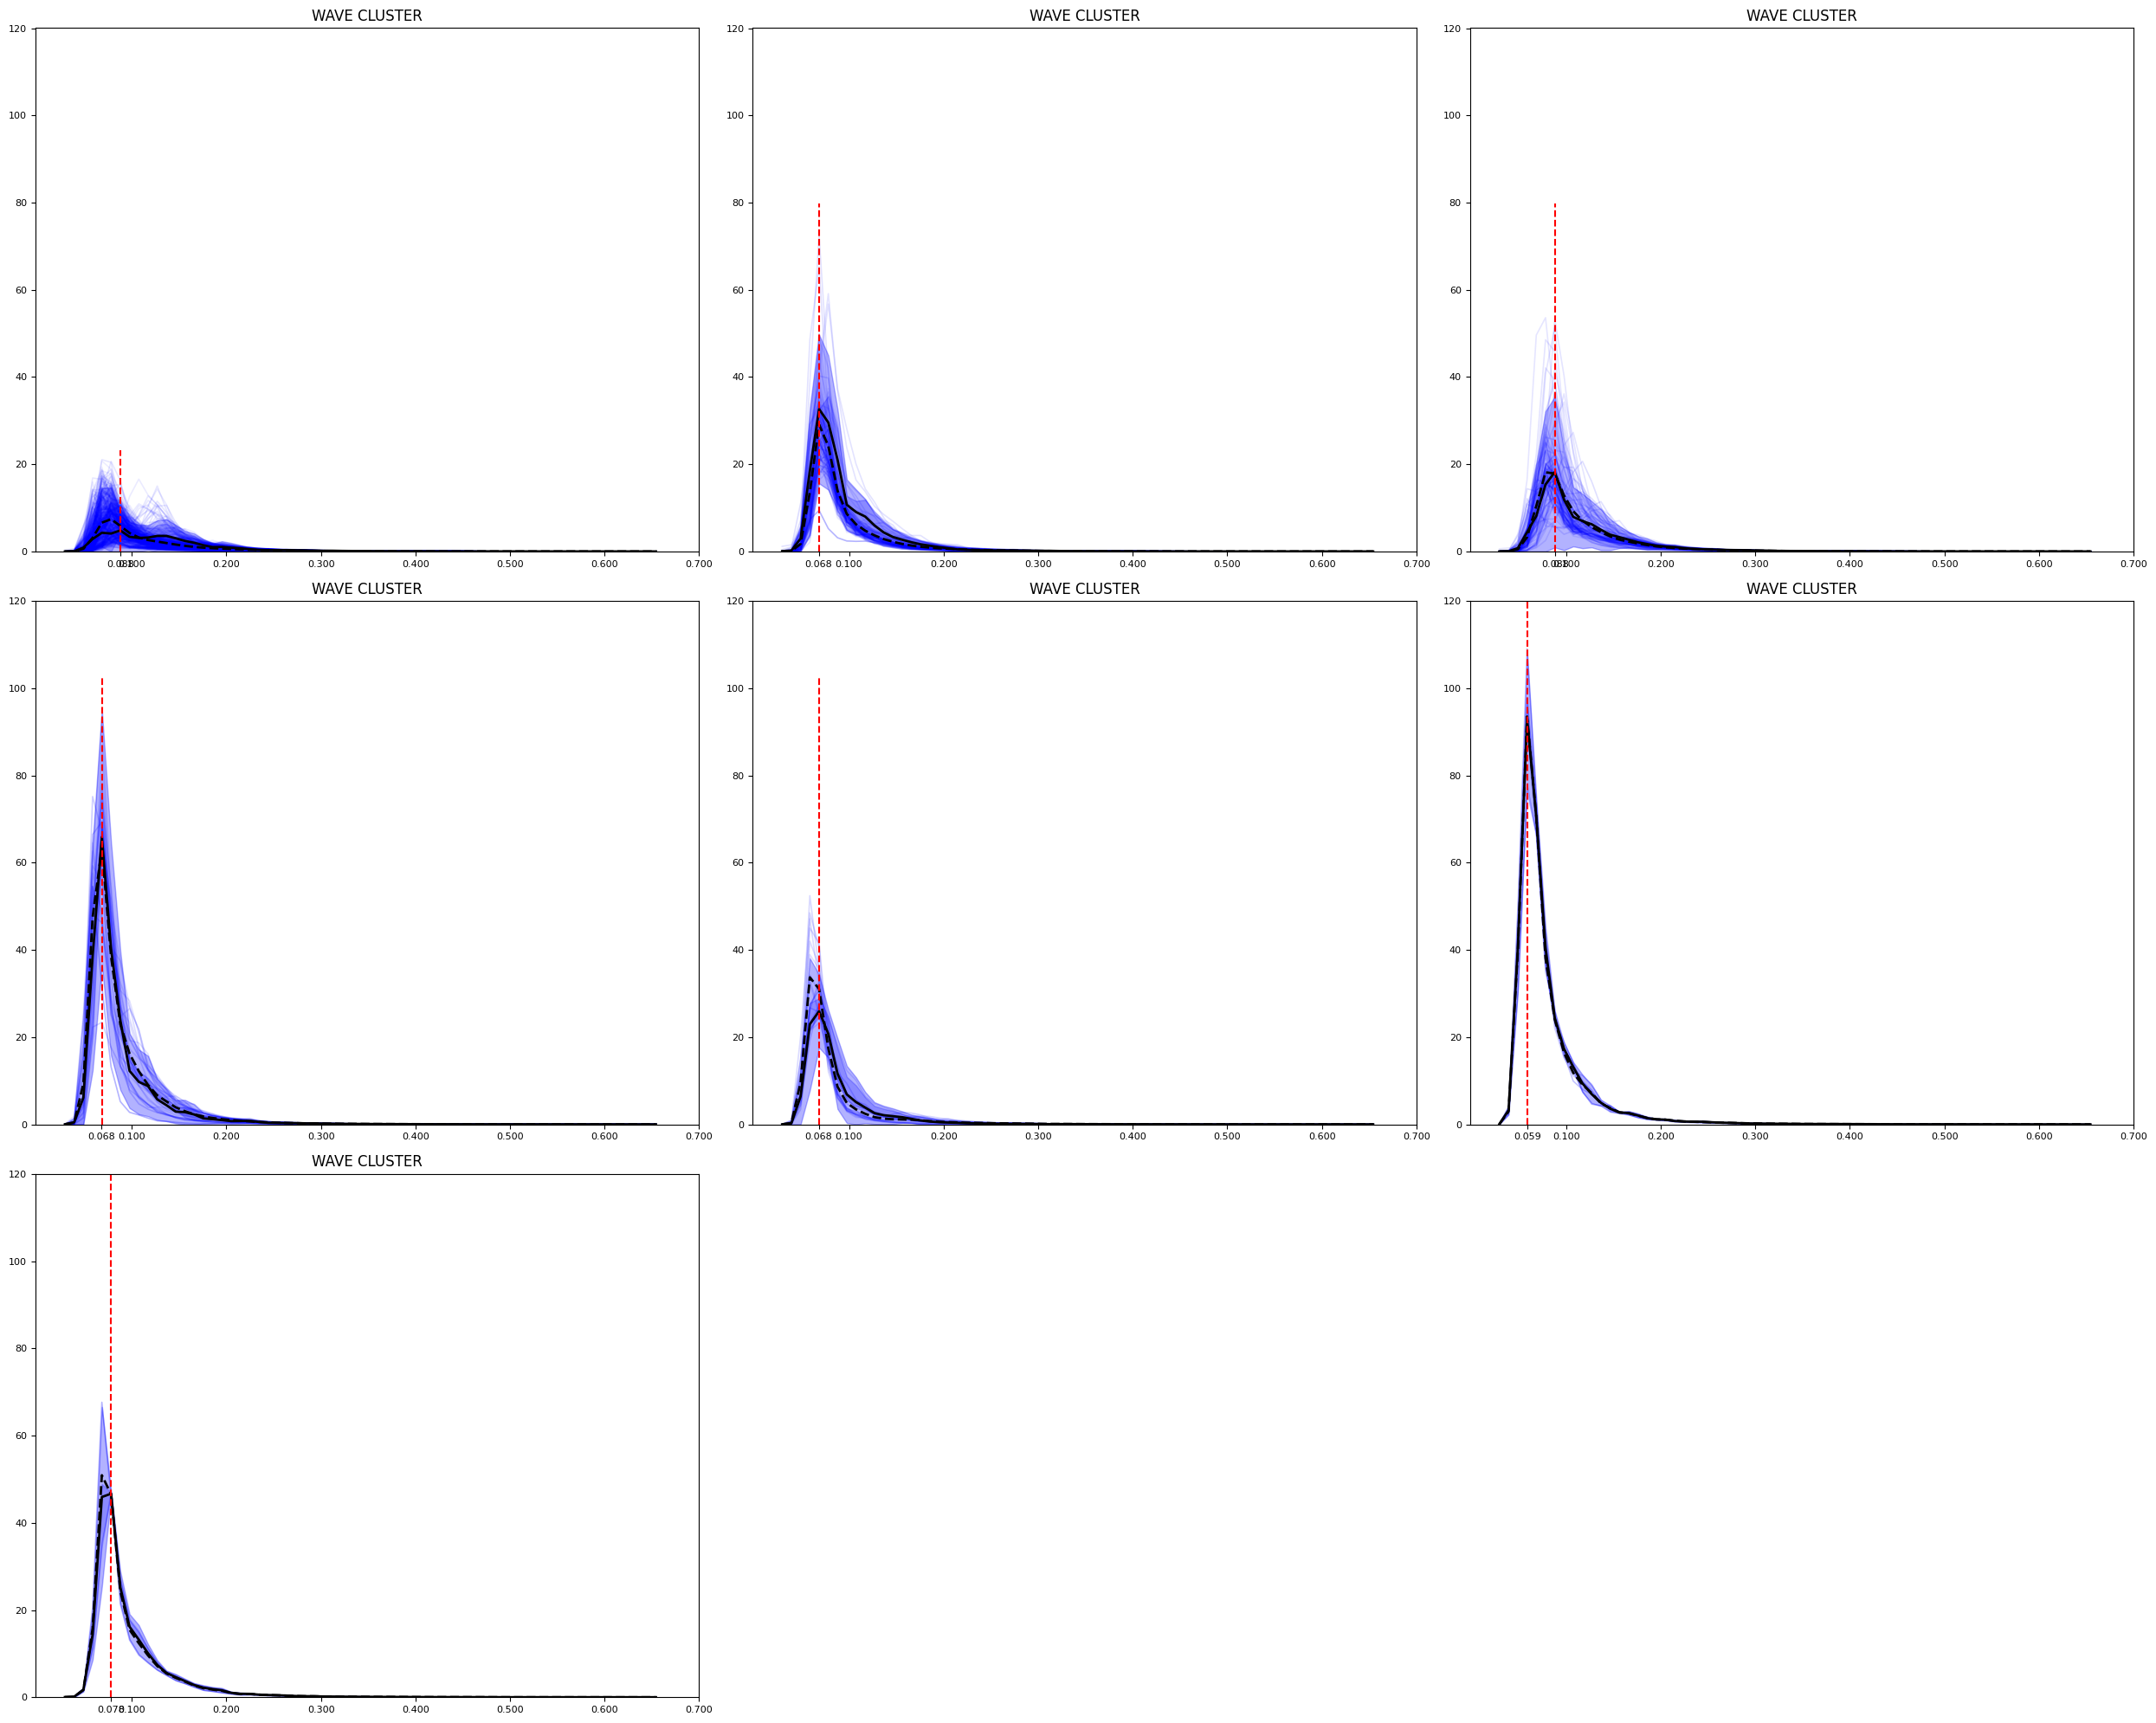

In [21]:

M = 2
sigma = [std * 1.0] * M
gamma = [std_dif * 1.0] * M
outputscale_ = 0.1
ini_lengthscale = 1e-3
bound_lengthscale = (1e-7, 5e-3)
samples = [0, num_obs_per_sample]
l, L = samples[0], samples[1]
# x_basis has to have the same dimension structure as data[0], in this case (171,1) but it could be (n_inducing_points, 1).
lim_freq = startFreq_sea
index_freq = np.where(freq_>lim_freq)[0][0]+1
x_basis = np.atleast_2d(freq_).T
x_train = np.atleast_2d(freq_).T
print(x_train.shape)
#If x_basis is wanted to be smaller than the observations length, then the inducing points approach can be applied setting this parameter to True.
inducing_points = False
#Choose if warp is going to be applied. (In the most recent version is optimized to work with online inference, but it can be used in offline as an additional step at the end of the clustering).
warp = False
#Warp priors
noise_warp = std * 0.1
bound_noise_warp = (noise_warp * 0.1, noise_warp * 0.2)
#Warp time indexes
x_basis_warp = np.atleast_2d(np.arange(freq_[0], freq_[-1], freq_.shape[0] / 2.0, dtype=np.float64)).T
sw_gp_drift06 = hdpgp.GPI_HDP(x_basis=x_basis, x_basis_warp=x_basis_warp, n_outputs=1,
                              ini_lengthscale=ini_lengthscale, bound_lengthscale=bound_lengthscale,
                              ini_gamma=gamma, ini_sigma=sigma, ini_outputscale=outputscale_, noise_warp=noise_warp,
                              bound_sigma=bound_sigma, bound_gamma=bound_gamma, bound_noise_warp=bound_noise_warp,
                              verbose=False, max_models=100, inducing_points=inducing_points,
                              reestimate_initial_params=False,
                              n_explore_steps=15, free_deg_MNIV=8, share_gp=True, use_snr=False, reduce_outputs=False)

cluster_labels_d08 = np.load('/home/adrian.perez/Documents/OceanWave/HDP-GPC/hdpgpc/ocean/cluster_labels/resampled_low_freq/cluster_labels_drift08_202407_dynamic_2.npy')
# ------ Cluster grouping on dynamic 2 ------
# cluster_labels_d08[np.where(cluster_labels_d08 == 5)] = 3
# cluster_labels_d08[np.where(cluster_labels_d08 == 6)] = 3
#
# #After-transform
# cluster_labels_d08[np.where(cluster_labels_d08 == 4)] = 1
# cluster_labels_d08[np.where(cluster_labels_d08 == 3)] = 1
# cluster_labels_d08[np.where(cluster_labels_d08 == 2)] = 1

# ------ Cluster grouping on dynamic 4 ------
# cluster_labels_d08[np.where(cluster_labels_d08 == 3)] = 2
# cluster_labels_d08[np.where(cluster_labels_d08 == 4)] = 2
# cluster_labels_d08[np.where(cluster_labels_d08 == 5)] = 2
# cluster_labels_d08[np.where(cluster_labels_d08 == 6)] = 2

M = np.unique(cluster_labels_d08).shape[0]
num_samples = data_drifting06.shape[0]
#logdata = np.log(data + 1e-6)
x_trains = np.array([x_train] * num_samples)
sw_gp_drift06.reload_model_from_labels(x_trains, data_drifting06, cluster_labels_d08, M)
labels = np.array(['N'] * 6500)
main_model = print_results(sw_gp_drift06, labels, 0, error=False)
selected_gpmodels = sw_gp_drift06.selected_gpmodels()
up.plot_models_plotly(sw_gp_drift06, selected_gpmodels, main_model, labels, N_0=0, lead=0, step=(freq_[1] - freq_[0]) / 1,
                      plot_latent=False, title='WAVE CLUSTER', ticks=True, yscale=True,
                      save="/home/adrian.perez/Documents/OceanWave/HDP-GPC/hdpgpc/ocean/clusters_drift06.png", line_max=True)

In [22]:
print(spec_time_drift03.shape)
from datetime import datetime, timedelta

def matlab_datenum_to_datetime(matlab_datenum):
    """
    Convert MATLAB datenum to Python datetime.
    """
    days = int(matlab_datenum)
    frac = matlab_datenum % 1
    python_datetime = datetime.fromordinal(days - 366) + timedelta(days=frac)
    return python_datetime

data_time_drift03 = [matlab_datenum_to_datetime(t) for t in spec_time_drift03[0]]
data_time_drift06 = [matlab_datenum_to_datetime(t) for t in spec_time_drift06[0]]
data_time_hillarys = [matlab_datenum_to_datetime(t) for t in spec_time_hillarys[0]]
print(np.min(data_time_hillarys), np.max(data_time_hillarys))
print(np.min(data_time_drift03), np.max(data_time_drift03))
print(np.min(data_time_drift06), np.max(data_time_drift06))


(1, 645)
2024-07-01 00:00:00 2024-08-31 23:29:59.999997
2024-07-01 00:02:30.999996 2024-08-31 22:02:31.000002
2024-07-01 00:14:59.999997 2024-08-31 23:40:00.000001


# Gráfica distribución por meses y clusters

In [23]:

df_hillarys = pd.DataFrame({
    'time': data_time_hillarys,
    'cluster': sw_gp_hillary.resp_assigned[-1]
})

# Crear columna cos días do ano (usado como eixo X)
df_hillarys['min'] = df_hillarys['time'].dt.minute
df_hillarys['hour'] = df_hillarys['time'].dt.hour
df_hillarys['day'] = df_hillarys['time'].dt.dayofyear  # Día do ano (1-365)
df_hillarys['month'] = df_hillarys['time'].dt.month    # Para ticks e estética
df_hillarys['date'] = df_hillarys['time'].dt.date

print(len(data_time_drift03))
print(len(sw_gp_drift03.resp_assigned[-1]))
df_drift03 = pd.DataFrame({
    'time': data_time_drift03,
    'cluster': sw_gp_drift03.resp_assigned[-1]
})

# Crear columna cos días do ano (usado como eixo X)
df_drift03['min'] = df_drift03['time'].dt.minute
df_drift03['hour'] = df_drift03['time'].dt.hour
df_drift03['day'] = df_drift03['time'].dt.dayofyear  # Día do ano (1-365)
df_drift03['month'] = df_drift03['time'].dt.month    # Para ticks e estética
df_drift03['date'] = df_drift03['time'].dt.date  # Por se queres filtrar por data concreta


df_drift06 = pd.DataFrame({
    'time': data_time_drift06,
    'cluster': sw_gp_drift06.resp_assigned[-1]
})

# Crear columna cos días do ano (usado como eixo X)
df_drift06['min'] = df_drift06['time'].dt.minute
df_drift06['hour'] = df_drift06['time'].dt.hour
df_drift06['day'] = df_drift06['time'].dt.dayofyear  # Día do ano (1-365)
df_drift06['month'] = df_drift06['time'].dt.month    # Para ticks e estética
df_drift06['date'] = df_drift06['time'].dt.date

index_limit = 20

frequencies_hillarys = freq_hillarys
energy_spectral = data
tensors_list_hillarys = []
std_list_hillarys = []
for gp in sw_gp_hillary.gpmodels[0]:
    subdata = np.mean(data[gp.indexes], axis=0)[:index_limit]
    cov = gp.Gamma[-1][:index_limit,:index_limit]
    tensors_list_hillarys.append(subdata)
    std_list_hillarys.append(cov)

frequencies_drift03 = frequency_drift03
energy_spectral = data_drifting03
tensors_list_drift03 = []
std_list_drift03 = []
for gp in sw_gp_drift03.gpmodels[0]:
    #subdata, cov = gp.observe(torch.from_numpy(frequencies_hillarys), t=-1)
    subdata = np.mean(data_drifting03[gp.indexes], axis=0)[:index_limit]
    cov = gp.Gamma[-1][:index_limit,:index_limit]
    tensors_list_drift03.append(subdata)
    std_list_drift03.append(cov)

frequencies_drift06 = frequency_drift06
energy_spectral = data_drifting06
tensors_list_drift06 = []
std_list_drift06 = []
for gp in sw_gp_drift06.gpmodels[0]:
    #subdata, cov = gp.observe(torch.from_numpy(frequencies_hillarys), t=-1)
    subdata = np.mean(data_drifting06[gp.indexes], axis=0)[:index_limit]
    cov = gp.Gamma[-1][:index_limit,:index_limit]
    tensors_list_drift06.append(subdata)
    std_list_drift06.append(cov)

clust_h, indexes_h = np.unique(sw_gp_hillary.resp_assigned[-1], return_index=True)

clust_d, indexes_d = np.unique(sw_gp_drift03.resp_assigned[-1], return_index=True)

clust_d6, indexes_d = np.unique(sw_gp_drift06.resp_assigned[-1], return_index=True)

tensors_list_hillarys = np.array(tensors_list_hillarys)[:,:,0]
tensors_list_drift03 = np.array(tensors_list_drift03)[:,:,0]
tensors_list_drift06 = np.array(tensors_list_drift06)[:,:,0]

std_list_hillarys = np.array(std_list_hillarys)
std_list_drift03 = np.array(std_list_drift03)
std_list_drift06 = np.array(std_list_drift06)
print(std_list_hillarys.shape)

n_clusters_hillarys = clust_h.shape[0]
n_clusters_drift03 = clust_d.shape[0]
n_clusters_drift06 = clust_d6.shape[0]

ds_cluster_means_hillarys = xr.Dataset(
    data_vars=dict(
        efth=(["cluster", "freq"], tensors_list_hillarys),
        std_mat = (["cluster", "freq", "freq_"], std_list_hillarys),
    ),
    coords=dict(
        cluster=(["cluster"], clust_h),
        freq=(["freq"], frequencies_hillarys[:index_limit]),
        freq_=(["freq_"], frequencies_hillarys[:index_limit])
))

ds_cluster_means_drift03 = xr.Dataset(
    data_vars=dict(
        efth=(["cluster", "freq"], tensors_list_drift03),
        std_mat = (["cluster", "freq", "freq_"], std_list_drift03),
    ),
    coords=dict(
        cluster=(["cluster"], clust_d),
        freq=(["freq"], frequencies_drift03[:index_limit]),
        freq_=(["freq_"], frequencies_drift03[:index_limit])
))

ds_cluster_means_drift06 = xr.Dataset(
    data_vars=dict(
        efth=(["cluster", "freq"], tensors_list_drift06),
        std_mat = (["cluster", "freq", "freq_"], std_list_drift06),
    ),
    coords=dict(
        cluster=(["cluster"], clust_d6),
        freq=(["freq"], frequencies_drift06[:index_limit]),
        freq_=(["freq_"], frequencies_drift06[:index_limit])
))

efth_ordered_hillarys = ds_cluster_means_hillarys['efth'].transpose('cluster', 'freq')

efth_ordered_drift03 = ds_cluster_means_drift03['efth'].transpose('cluster', 'freq')

efth_ordered_drift06 = ds_cluster_means_drift06['efth'].transpose('cluster', 'freq')


645
645
(10, 20, 20)


In [24]:

gp_b = sw_gp_hillary.gpmodels[0][0]
x_bas = gp_b.x_basis
dist_clusters_hillarys = []
dist_clusters_drift03 = []
dist_clusters_drift06 = []
order='sum_energy'
##Order of clusters from similar to disimilar with respect to Hillarys 0.
if order == 'KL_similarity':
    for i in range(n_clusters_hillarys):
        dist = 0
        for j in range(sw_gp_hillary.n_outputs):
            gp_b = sw_gp_hillary.gpmodels[j][0]
            gp = sw_gp_hillary.gpmodels[j][i]
            x_bas = gp.x_basis
            dist = dist + gp_b.KL_divergence(len(gp_b.indexes)-1, gp,len(gp.indexes)-1, x_bas=x_bas)
        dist_clusters_hillarys.append(dist)
    for i in range(n_clusters_drift03):
        dist = 0
        for j in range(sw_gp_hillary.n_outputs):
            gp_b = sw_gp_hillary.gpmodels[j][0]
            gp = sw_gp_drift03.gpmodels[j][i]
            x_bas = gp.x_basis
            dist = dist + gp_b.KL_divergence(len(gp_b.indexes)-1, gp,len(gp.indexes)-1, x_bas=x_bas)
        dist_clusters_drift03.append(dist)
    for i in range(n_clusters_drift06):
        dist = 0
        for j in range(sw_gp_hillary.n_outputs):
            gp_b = sw_gp_hillary.gpmodels[j][0]
            gp = sw_gp_drift06.gpmodels[j][i]
            x_bas = gp.x_basis
            dist = dist + gp_b.KL_divergence(len(gp_b.indexes)-1, gp,len(gp.indexes)-1, x_bas=x_bas)
        dist_clusters_drift06.append(dist)
elif order == 'ocurrence':
    ## Order by occurrence
    dist_clusters_hillarys = [gp.indexes[0] for gp in sw_gp_hillary.gpmodels[0]]
    dist_clusters_drift03 = [gp.indexes[0] for gp in sw_gp_drift03.gpmodels[0]]
    dist_clusters_drift06 = [gp.indexes[0] for gp in sw_gp_drift06.gpmodels[0]]
elif order == 'sum_energy':
    #Order by energy
    dist_clusters_hillarys = np.zeros(n_clusters_hillarys)
    for i in range(sw_gp_hillary.n_outputs):
        dist_clusters_hillarys = dist_clusters_hillarys + np.array([torch.sum(gp.f_star_sm[-1]) for gp in sw_gp_hillary.gpmodels[i]])
    dist_clusters_drift03 = np.zeros(n_clusters_drift03)
    for i in range(sw_gp_drift03.n_outputs):
        dist_clusters_drift03 = dist_clusters_drift03 + np.array([torch.sum(gp.f_star_sm[-1]) for gp in sw_gp_drift03.gpmodels[i]])
    dist_clusters_drift06 = np.zeros(n_clusters_drift06)
    for i in range(sw_gp_drift06.n_outputs):
        dist_clusters_drift06 = dist_clusters_drift06 + np.array([torch.sum(gp.f_star_sm[-1]) for gp in sw_gp_drift06.gpmodels[i]])
elif order == 'max_energy_frequency':
    dist_clusters_hillarys = np.zeros(n_clusters_hillarys)
    for i in range(n_clusters_hillarys):
        dist_clusters_hillarys[i] = sw_gp_hillary.gpmodels[0][i].x_train[0][np.argmax(np.sum(np.array([gps[i].f_star_sm[-1][:,0] for gps in sw_gp_hillary.gpmodels]), axis=0))]
    dist_clusters_drift03 = np.zeros(n_clusters_drift03)
    for i in range(n_clusters_drift03):
        dist_clusters_drift03[i] = sw_gp_drift03.gpmodels[0][i].x_train[0][np.argmax(np.sum(np.array([gps[i].f_star_sm[-1] for gps in sw_gp_drift03.gpmodels]), axis=0))]
    dist_clusters_drift06 = np.zeros(n_clusters_drift06)
    for i in range(n_clusters_drift06):
        dist_clusters_drift06[i] = sw_gp_drift06.gpmodels[0][i].x_train[0][np.argmax(np.sum(np.array([gps[i].f_star_sm[-1] for gps in sw_gp_drift06.gpmodels]), axis=0))]
n_clusters_hillarys_ord = np.argsort(dist_clusters_hillarys)
n_clusters_drift03_ord = np.argsort(dist_clusters_drift03)
n_clusters_drift06_ord = np.argsort(dist_clusters_drift06)

pos_clusters_hillarys_ord = np.arange(dist_clusters_hillarys.shape[0])
pos_clusters_drift03_ord = np.arange(dist_clusters_drift03.shape[0])
pos_clusters_drift06_ord = np.arange(dist_clusters_drift06.shape[0])
#n_clusters_hillarys_ord = np.array([0,1,2,3])
print(dist_clusters_hillarys)
print(n_clusters_hillarys_ord)


[39.47560792 30.40658086 38.1748103  14.29106655 46.34756044 39.58693948
 53.55780806 36.7999311  71.9515331  71.12878708]
[3 1 7 2 0 5 4 6 9 8]


In [25]:
from matplotlib import gridspec
from wavespectra import specarray


def plot_cluster_spectrum_and_timeline_list(df_, efth_ordered_, pos_clusters_, n_clusters_, title="", save=None):
    cols = ['b', 'r', 'g', 'y']
    num_models = len(df_)
    fig = plt.figure(figsize=(30, 8))
    width_rad = [0.1/num_models] * num_models
    width_rad = width_rad.append(0.9)
    width_rad = [0.05, 0.05, 0.05, 0.7]
    num_clust_max = np.max(np.array([n.shape for n in n_clusters_]))
    gs = gridspec.GridSpec(num_clust_max, num_models+1, width_ratios=width_rad, hspace = 0.3,)
    efth_max_int = 0.0
    efth_min_int = 0.0
    for mod in range(num_models):
        efth_max_int = np.max([efth_max_int, np.max(efth_ordered_[mod].values)])
        efth_min_int = np.min([efth_min_int, np.min(efth_ordered_[mod].values)])

    # Panel de dispersión
    ax_scatter = plt.subplot(gs[:, -1])
    for mod in range(num_models):
        col = cols[mod]
        df = df_[mod]
        efth_ordered = efth_ordered_[mod]
        n_clusters = n_clusters_[mod]
        pos_clusters = pos_clusters_[mod]

        efth_max = efth_ordered.max().item()
        efth_min = efth_ordered.min().item()

        for j_ in n_clusters:
            da = efth_ordered.isel(cluster=j_)

            max_freq = da['freq'][np.argmax(da.values[np.where(da['freq']<0.30)])]
            g = 9.81  # m/s^2
            wave_speed = (g / (4 * np.pi * max_freq)) / 1000 * 3600


            ax_ = plt.subplot(gs[n_clusters.shape[0]-pos_clusters[j_]-1 +(num_clust_max-n_clusters.shape[0]), mod])
            ax_.plot(da['freq'][np.where(da['freq']<0.30)], da.values[np.where(da['freq']<0.30)])
            ax_.axvline(da['freq'][np.argmax(da.values[np.where(da['freq']<0.30)])], color='r')
            ax_.set_ylim((efth_min_int, efth_max_int))
            ax_.set_yticklabels([])
            x_ticks = np.append(ax_.get_xticks()[2:], np.round(max_freq, 3))
            ax_.set_xticks(x_ticks)
            ax_.tick_params(axis='both', which='major', labelsize=6)
            ax_.set_title(f"Cluster {j_}, Per {np.round(1/max_freq,3).item()}, Time {np.round(4000/ (wave_speed*24.0), 2).item()}.", fontsize=5, y = 0.96)
            #ax_.set_xticklabels(x_ticks)

        #x_jittered = rand_jitter(df['day'].values)
        x_jittered = df['day'].values + df['hour'].values/24.0 + df['min'].values/1440.0
        #y_jittered = rand_jitter(df['cluster'].values)

        ord_clust = np.array([np.where(n_clusters==cl)[0] for cl in df['cluster'].values])
        ord_clust = np.array([pos_clusters[cl] for cl in ord_clust])
        ax_scatter.scatter(x_jittered, ord_clust - 0.1*mod, s=70, color=col, alpha=0.5)
        if mod==0:
            month_start_days = df.groupby('month')['day'].min()
            month_labels_presentes = ['Xan', 'Feb', 'Mar', 'Abr', 'Mai', 'Xuñ', 'Xul', 'Ago', 'Set', 'Out', 'Nov', 'Dec']
            month_labels_filtrados = [month_labels_presentes[m - 1] for m in month_start_days.index]

            days = df['day'].values
            labels_days = df['time'].dt.day.values

            ax_scatter.set_xticks(month_start_days.values)
            ax_scatter.set_xticklabels(month_labels_filtrados)
            ax_scatter.set_xticks(days, minor=True)
            ax_scatter.set_xticklabels(labels_days, minor=True)

            #ax_scatter.set_yticks([])
            ax_scatter.set_xlabel("Mes")
            ax_scatter.set_title("Daily distribution of cluster spectra "+title)
            ax_scatter.grid(which='major', alpha=0.5)
            ax_scatter.grid(which='minor', linestyle="--", alpha=0.1)
            #ax_scatter.legend()

    if save:
        dirname = "/home/adrian.perez/Documents/OceanWave/HDP-GPC/hdpgpc/ocean/"
        os.makedirs(dirname, exist_ok=True)
        fig.savefig(dirname + save, dpi=300)

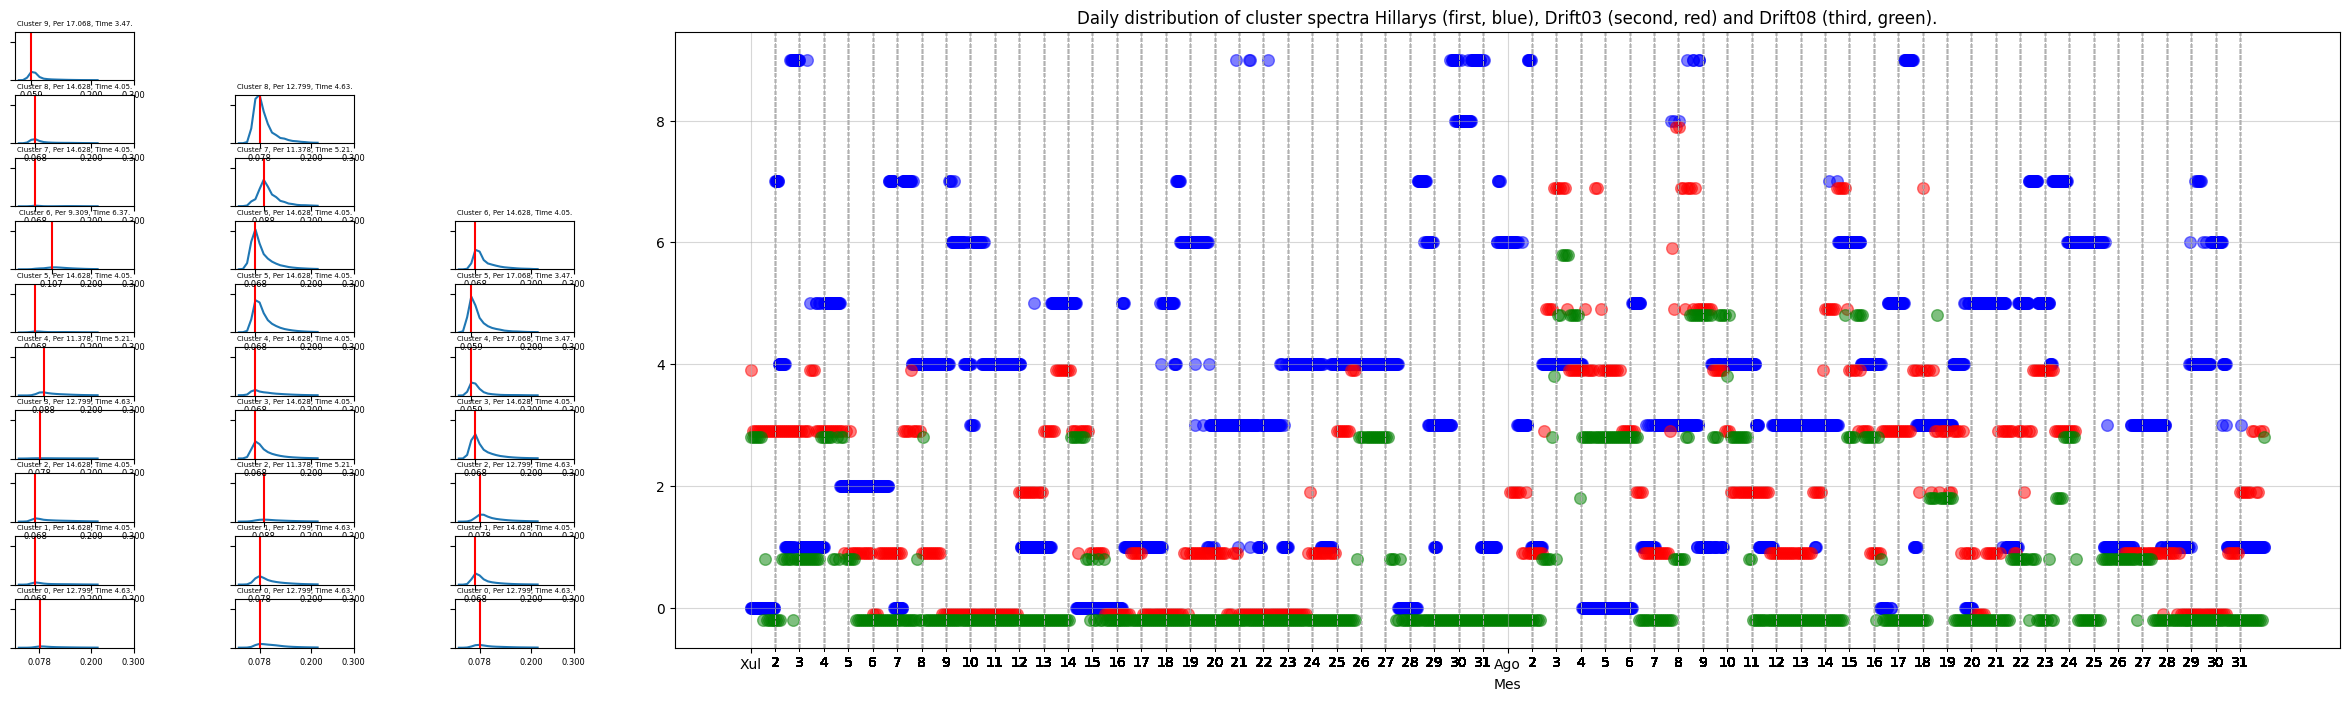

In [26]:
plot_cluster_spectrum_and_timeline_list([df_hillarys, df_drift03, df_drift06], [efth_ordered_hillarys, efth_ordered_drift03, efth_ordered_drift06], [pos_clusters_hillarys_ord, pos_clusters_drift03_ord, pos_clusters_drift06_ord], [n_clusters_hillarys_ord, n_clusters_drift03_ord, n_clusters_drift06_ord], title="Hillarys (first, blue), Drift03 (second, red) and Drift08 (third, green).", save="Buoy_cluster_comparison.png")

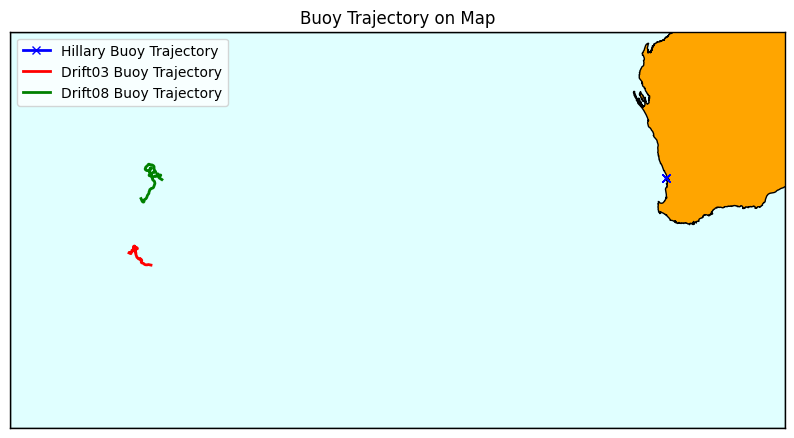

In [27]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

lon_h = np.array(f_hillary.get('SpotData/lon')).squeeze()
lat_h = np.array(f_hillary.get('SpotData/lat')).squeeze()
lon_d03 = np.array(f_drift03.get('SpotData/lon')).squeeze()
lat_d03 = np.array(f_drift03.get('SpotData/lat')).squeeze()
lon_d06 = np.array(f_drift06.get('SpotData/lon')).squeeze()
lat_d06 = np.array(f_drift06.get('SpotData/lat')).squeeze()

min_lat = np.min(np.concatenate([lat_h, lat_d03, lat_d06]))
max_lat = np.max(np.concatenate([lat_h, lat_d03, lat_d06]))
min_lon = np.min(np.concatenate([lon_h, lon_d03, lon_d06]))
max_lon = np.max(np.concatenate([lon_h, lon_d03, lon_d06]))

plt.figure(figsize=(10, 8))
m = Basemap(projection='merc',
            llcrnrlat=min_lat-10.0, urcrnrlat=max_lat+10.0,
            llcrnrlon=min_lon-10.0, urcrnrlon=max_lon+10.0,
            resolution='i')

m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color='orange', lake_color='aqua')
m.drawmapboundary(fill_color='lightcyan')

x, y = m(lon_h, lat_h)
m.plot(x, y, marker='x', color='b', linewidth=2.0, label='Hillary Buoy Trajectory')
x, y = m(lon_d03, lat_d03)
m.plot(x, y, color='r', linewidth=2.0, label='Drift03 Buoy Trajectory')
x, y = m(lon_d06, lat_d06)
m.plot(x, y, color='g', linewidth=2.0, label='Drift08 Buoy Trajectory')
plt.title('Buoy Trajectory on Map')
plt.legend()
plt.savefig('/home/adrian.perez/Documents/OceanWave/HDP-GPC/hdpgpc/ocean/map.png')
plt.show()


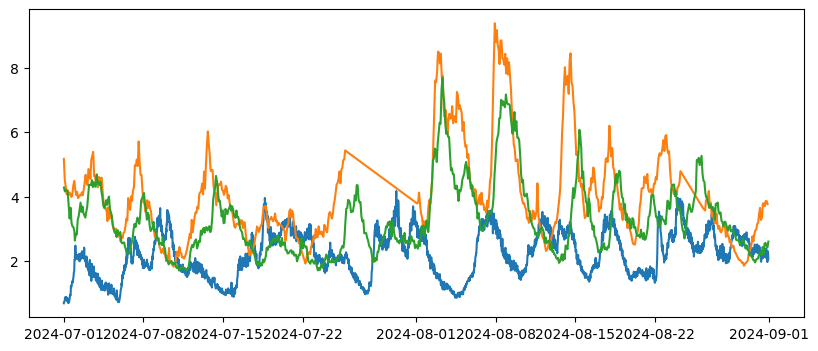

In [28]:
fig = plt.figure(figsize=(10,4))
plt.plot(data_time_hillarys, hs_h)
plt.plot(data_time_drift03, hs_d03)
plt.plot(data_time_drift06, hs_d06)

## Co-occurrence frequency matrix cluster identification

Implementation of frequency matrix to identify cluster assignation using the occurrence.

In [29]:
def cooccurrence_matching(labels_buoy1, labels_buoy2,
                          times_buoy1, times_buoy2,
                          lag_range=(0, 10), window_hours=24):
    """
    Match clusters based on co-occurrence frequency within time windows

    Parameters:
    - lag_range: (min_days, max_days) expected propagation time
    - window_hours: time window for counting co-occurrences
    """
    n_clusters1 = labels_buoy1.max() + 1
    n_clusters2 = labels_buoy2.max() + 1

    # Co-occurrence count matrix for each lag
    lag_days = np.arange(lag_range[0], lag_range[1] + 1)
    cooccur_counts = np.zeros((n_clusters1, n_clusters2, len(lag_days)))

    for lag_idx, lag in enumerate(lag_days):
        lag_hours = lag * 24

        for i in range(n_clusters1):
            # Times when cluster i occurs at buoy 1
            times_i = times_buoy1[labels_buoy1 == i]

            for j in range(n_clusters2):
                # Times when cluster j occurs at buoy 2
                times_j = times_buoy2[labels_buoy2 == j]

                # Count co-occurrences within window
                count = 0
                for t1 in times_i:
                    # Expected arrival time at buoy 2
                    expected_t2 = t1 + np.timedelta64(lag_hours, 'h')

                    # Check if cluster j occurred near expected time
                    time_diffs = np.abs(times_j - expected_t2)
                    if (time_diffs <= np.timedelta64(window_hours, 'h')).any():
                        count += 1

                cooccur_counts[i, j, lag_idx] = count

    # Find best match for each cluster
    best_matches = {}
    for i in range(n_clusters1):
        # Find cluster j and lag with maximum co-occurrences
        best_j, best_lag_idx = np.unravel_index(
            cooccur_counts[i, :, :].argmax(),
            cooccur_counts[i, :, :].shape
        )

        best_matches[i] = {
            'matched_cluster': best_j,
            'lag_days': lag_days[best_lag_idx],
            'cooccurrence_count': cooccur_counts[i, best_j, best_lag_idx]
        }

    return cooccur_counts, best_matches


def estimate_propagation_time(freq, drift_spectrum,
                               drift_position, coast_position):
    """
    Estimate propagation time based on swell period and distance
    
    Parameters:
    - drift_spectrum: directional spectrum at drift buoy
    - coast_spectrum: directional spectrum at coastal buoy
    - drift_position, coast_position: (lat, lon) tuples
    
    Returns:
    - expected_lag_days: estimated propagation time in days
    - lag_uncertainty_days: uncertainty range
    """
    # Extract peak period from drift buoy spectrum
    peak_freq = freq[np.argmax(drift_spectrum)]
    peak_period = 1.0 / peak_freq  # seconds
    
    # Compute group velocity (deep water)
    g = 9.81  # m/s^2
    C_g = (g * peak_period) / (4 * np.pi)  # m/s
    
    # Compute great circle distance
    distance_km = great_circle_distance(drift_position, coast_position)
    distance_m = distance_km * 1000
    
    # Propagation time
    travel_time_sec = distance_m / C_g
    travel_time_days = travel_time_sec / (24 * 3600)
    
    # Uncertainty (±20% for period variability and dispersion)
    lag_uncertainty_days = 0.2 * travel_time_days
    
    return travel_time_days, lag_uncertainty_days

def great_circle_distance(pos1, pos2):
    """Compute great circle distance in km"""
    from math import radians, cos, sin, asin, sqrt
    
    lat1, lon1 = radians(pos1[0]), radians(pos1[1])
    lat2, lon2 = radians(pos2[0]), radians(pos2[1])
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    
    R = 6371  # Earth radius in km
    return R * c

def adaptive_lagged_cooccurrence(labels_drift, times_drift, spectra_drift,
                                  labels_coast, times_coast, spectra_coast,
                                  drift_position, coast_position,
                                  cluster_centroids_drift):
    """
    Compute co-occurrence with adaptive lag range based on 
    spectral characteristics of each cluster
    """
    n_drift = labels_drift.max() + 1
    n_coast = labels_coast.max() + 1
    
    # Initialize results
    cooccur_scores = np.zeros((n_drift, n_coast))
    optimal_lags = np.zeros((n_drift, n_coast))
    
    for i in range(n_drift):
        # Get centroid spectrum for drift cluster i
        centroid_spectrum_i = cluster_centroids_drift[i]
        
        # Estimate expected propagation time for this cluster
        expected_lag, lag_uncertainty = estimate_propagation_time(
            centroid_spectrum_i, None,  # Don't need coast spectrum
            drift_position, coast_position
        )
        
        # Define cluster-specific lag range
        lag_min = max(0, expected_lag - 2 * lag_uncertainty)
        lag_max = expected_lag + 2 * lag_uncertainty
        lag_range_i = (lag_min, lag_max)
        
        # Get times when cluster i occurs at drift buoy
        drift_times_i = times_drift[labels_drift == i]
        
        for j in range(n_coast):
            coast_times_j = times_coast[labels_coast == j]
            
            # Scan over cluster-specific lag range
            best_count = 0
            best_lag = expected_lag
            
            for lag_days in np.arange(lag_min, lag_max, 0.25):
                count = count_cooccurrences(drift_times_i, coast_times_j,
                                           lag_days, window_hours=24)
                
                if count > best_count:
                    best_count = count
                    best_lag = lag_days
            
            cooccur_scores[i, j] = best_count
            optimal_lags[i, j] = best_lag
    
    return cooccur_scores, optimal_lags

def count_cooccurrences(times1, times2, lag_days, window_hours):
    """Count how many times1 events have corresponding times2 events"""
    lag_td = timedelta(days=lag_days)
    window_td = timedelta(hours=window_hours)
    
    count = 0
    for t1 in times1:
        expected_t2 = t1 + lag_td
        time_diffs = np.abs(times2 - expected_t2)
        if np.any(time_diffs <= window_td):
            count += 1
    
    return count

In [36]:
print(cluster_labels_h.shape, np.array(data_time_hillarys).shape)
cooccur_counts, best_matches = cooccurrence_matching(cluster_labels_h, cluster_labels_d03, np.array(data_time_hillarys), np.array(data_time_drift03), lag_range=(2,6), window_hours=24)
print(best_matches)

(2936,) (2936,)
{0: {'matched_cluster': np.int64(1), 'lag_days': np.int64(0), 'cooccurrence_count': np.float64(368.0)}, 1: {'matched_cluster': np.int64(0), 'lag_days': np.int64(1), 'cooccurrence_count': np.float64(443.0)}, 2: {'matched_cluster': np.int64(0), 'lag_days': np.int64(3), 'cooccurrence_count': np.float64(446.0)}, 3: {'matched_cluster': np.int64(0), 'lag_days': np.int64(3), 'cooccurrence_count': np.float64(231.0)}, 4: {'matched_cluster': np.int64(0), 'lag_days': np.int64(5), 'cooccurrence_count': np.float64(254.0)}, 5: {'matched_cluster': np.int64(0), 'lag_days': np.int64(5), 'cooccurrence_count': np.float64(259.0)}, 6: {'matched_cluster': np.int64(2), 'lag_days': np.int64(5), 'cooccurrence_count': np.float64(89.0)}, 7: {'matched_cluster': np.int64(0), 'lag_days': np.int64(0), 'cooccurrence_count': np.float64(96.0)}, 8: {'matched_cluster': np.int64(0), 'lag_days': np.int64(3), 'cooccurrence_count': np.float64(76.0)}, 9: {'matched_cluster': np.int64(1), 'lag_days': np.int64(3)

In [33]:
print(lon_h[0], lat_h[0])
print(lon_d03[0], lat_d03[0])
print(lon_d06[0], lat_d06[0])

# main_model = print_results(sw_gp_hillary, labels, 0, error=False)
# up.plot_models_plotly(sw_gp_hillary, [8], main_model, labels, N_0=0, lead=1, step=(freq[1]-freq[0])/1,
#                    plot_latent=False, title='WAVE CLUSTER',ticks=True, yscale=True)
# main_model = print_results(sw_gp_drift06, labels, 0, error=False)
# up.plot_models_plotly(sw_gp_drift06, [14], main_model, labels, N_0=0, lead=1, step=(freq[1] - freq[0]) / 1,
#                       plot_latent=False, title='WAVE CLUSTER', ticks=True, yscale=True)


print(sw_gp_hillary.gpmodels[0][16].x_train[0][np.argmax(sw_gp_hillary.gpmodels[0][16].f_star[-1])])
print(sw_gp_drift03.gpmodels[0][1].x_train[0][np.argmax(sw_gp_drift06.gpmodels[0][1].f_star[-1])])
print(sw_gp_drift06.gpmodels[0][2].x_train[0][np.argmax(sw_gp_drift06.gpmodels[0][2].f_star[-1])+1])

plt.figure()
plt.plot(sw_gp_hillary.gpmodels[0][16].x_train[0],sw_gp_hillary.gpmodels[0][16].f_star[-1], 'b')
plt.plot(sw_gp_drift03.gpmodels[0][1].x_train[0],sw_gp_drift03.gpmodels[0][1].f_star[-1], 'r')
plt.plot(sw_gp_drift06.gpmodels[0][2].x_train[0],sw_gp_drift06.gpmodels[0][2].f_star[-1], 'g')
plt.vlines(0.078, 0,70)
plt.show()


115.64628 -31.85168
70.51448 -37.05543
71.52583 -33.32688


IndexError: list index out of range

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from plotly.offline import plot
import plotly.io as pio
pio.renderers.default = 'notebook_connected'
pio.templates.default = 'plotly'

def plot_spectral_grid_mean(cluster_means, frequencies, directions):
    """
    Plots 3D spectral energy distributions using cluster mean tensors.

    Parameters:
        cluster_means (list of np.ndarray): List of K tensors representing cluster means.
        frequencies (np.ndarray): Frequency array corresponding to the clusters.
        directions (np.ndarray): Direction array corresponding to the clusters.
    """
    num_clusters = len(cluster_means)
    cols = min(2, num_clusters)
    rows = (num_clusters // cols) + (num_clusters % cols > 0)

    fig = make_subplots(
        rows=rows,
        cols=cols,
        subplot_titles=[f'Cluster {i__+1}' for i__ in range(num_clusters)],
        specs=[[{'type': 'surface'}] * cols for _ in range(rows)]
    )

    # Ensure directions include both 0° and 360°
    directions = np.append(directions, 360.0)  # Add 360° to the directions array
    directions_rad = np.radians(directions)  # Convert to radians

    # Extend cluster_means by repeating the values for 0° at 360°
    for i_ in range(len(cluster_means)):
        cluster_means[i_] = np.concatenate([cluster_means[i_], cluster_means[i_][:, [0]]], axis=1)

    # Generate meshgrid for plotting
    Freq, Theta = np.meshgrid(frequencies, directions_rad)
    X = Freq * np.cos(Theta)  # Use Freq as radial and Theta as angular
    Y = Freq * np.sin(Theta)

    # Loop through each cluster mean tensor and plot
    for idx, cluster_mean in enumerate(cluster_means):
        row, col = divmod(idx, cols)

        Z = cluster_mean.T  # Transpose for correct orientation

        surface = go.Surface(
            x=X,
            y=-Y,
            z=Z,
            colorscale='Spectral_r',
            opacity=1,
            showlegend=False,
            showscale=False
        )
        fig.add_trace(surface, row=row+1, col=col+1)

        # Add circles and directional labels
        max_frequency = np.max(frequencies)
        circle_radii = [0.75 * max_frequency, 0.5 * max_frequency, 0.25 * max_frequency]

        for freq in circle_radii:
            circle_x = freq * np.cos(np.linspace(0, 2 * np.pi, 100))
            circle_y = freq * np.sin(np.linspace(0, 2 * np.pi, 100))
            fig.add_trace(go.Scatter3d(
                x=circle_x,
                y=circle_y,
                z=np.zeros_like(circle_x),
                mode='lines',
                line=dict(color='black', width=0.5, dash='dash'),
                showlegend=False
            ), row=row+1, col=col+1)

        border_x = max_frequency * np.cos(np.linspace(0, 2 * np.pi, 100))
        border_y = max_frequency * np.sin(np.linspace(0, 2 * np.pi, 100))
        fig.add_trace(go.Scatter3d(
            x=border_x,
            y=border_y,
            z=np.zeros_like(border_x),
            mode='lines',
            line=dict(color='black', width=1),
            showlegend=False
        ), row=row+1, col=col+1)

        for angle in range(0, 360, 45):
            rad = np.radians(-angle)
            x = max_frequency * np.cos(rad)
            y = max_frequency * np.sin(rad)

            fig.add_trace(go.Scatter3d(
                x=[0, x],
                y=[0, y],
                z=[0, 0],
                mode='lines',
                line=dict(color='black', width=0.5, dash='dash'),
                showlegend=False
            ), row=row+1, col=col+1)
            fig.add_trace(go.Scatter3d(
                x=[x],
                y=[y],
                z=[0],
                mode='text',
                text=[f"{angle}°"],
                showlegend=False,
                textposition='bottom center'
            ), row=row+1, col=col+1)

    fig.update_layout(
        height=800 * rows,
        width=600 * cols,
        title_text='Cluster Mean Spectral Energy Distributions',
        showlegend=False,
    )

    for i in range(1, num_clusters + 1):
        fig.update_scenes(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=True),  # Ensure consistent z-axis scaling
            zaxis_range=[0, np.max(cluster_means)],  # Force consistent scale across plots
            bgcolor='rgba(0,0,0,0)',
            row=(i - 1) // cols + 1,
            col=(i - 1) % cols + 1
        )

    fig.show(renderer="svg")
    plot(fig, auto_open=False, filename='/home/adrian.perez/Documents/OceanWave/HDP-GPC/hdpgpc/ocean/plots/plot_means_directional_6.html')

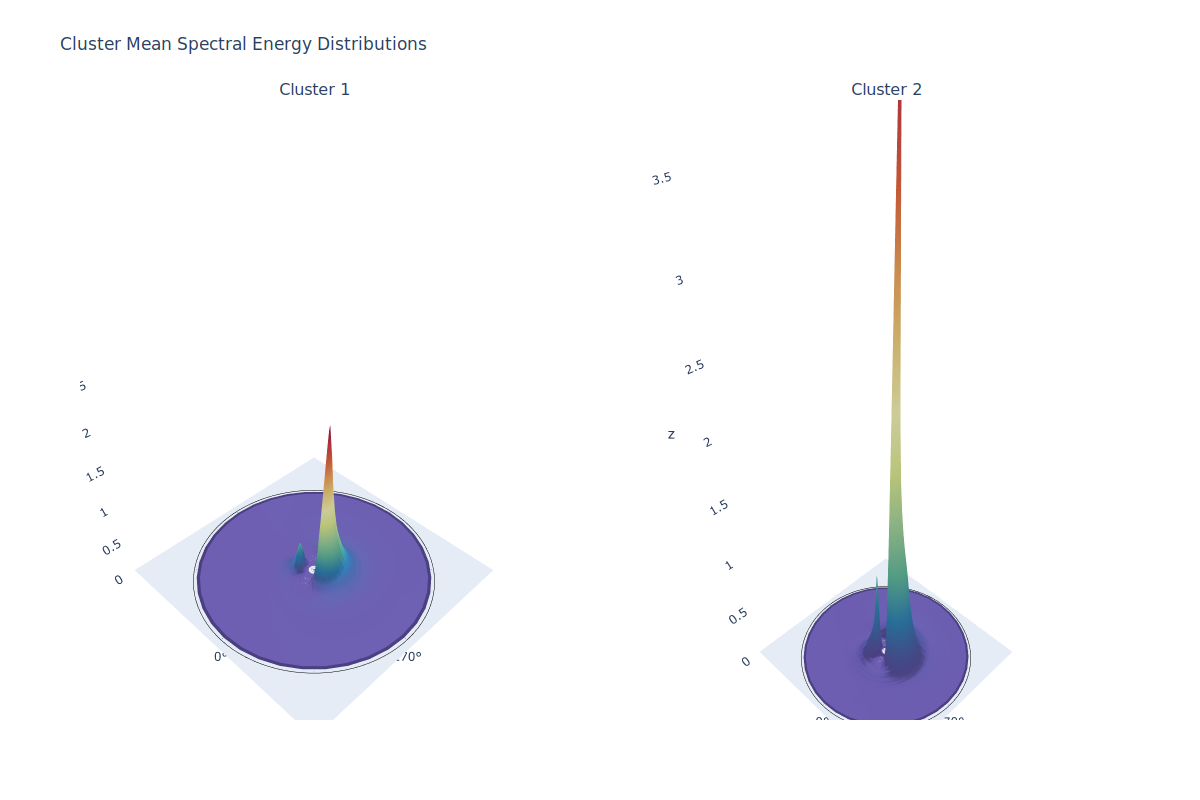

In [34]:
frequencies = freq_
directions_ = np.rad2deg(directions)
energy_spectral = data
tensors_list = []
for gp in sw_gp_hillary.gpmodels[0][:2]:
    subdata = np.mean(data[gp.indexes], axis=0)
    tensors_list.append(subdata)
plot_spectral_grid_mean(cluster_means=tensors_list, frequencies=frequencies, directions=directions_)

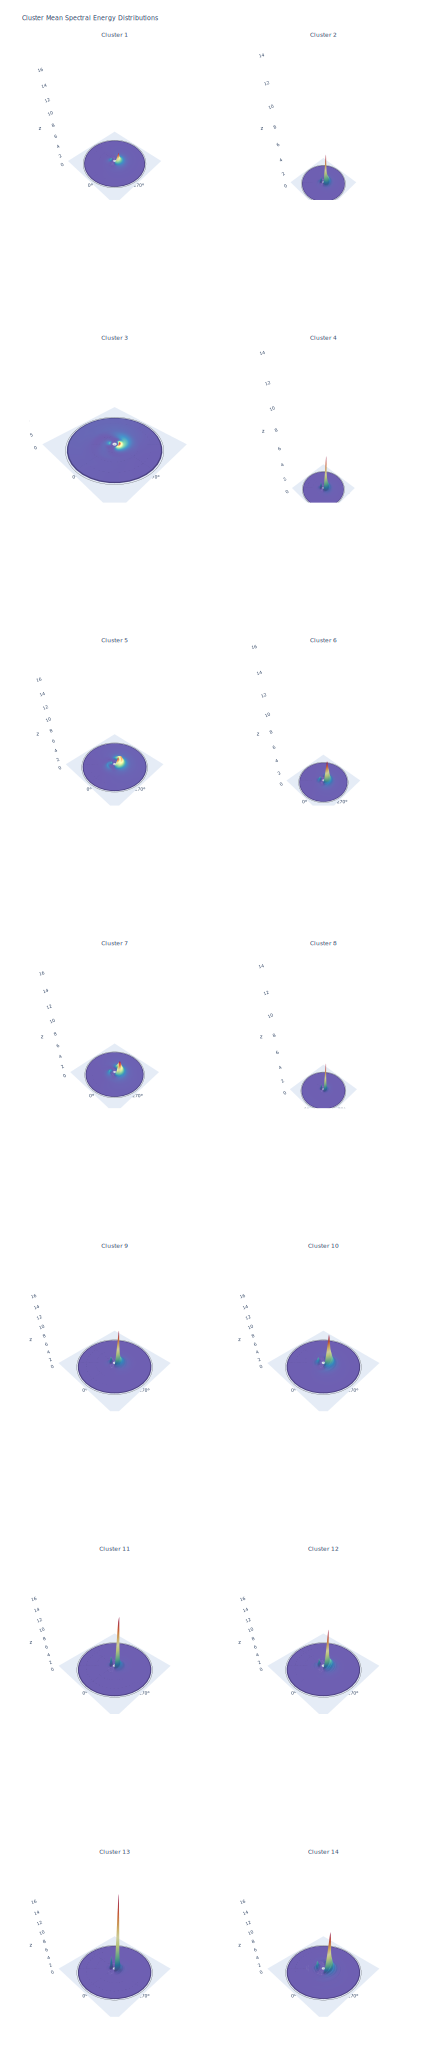

In [35]:
frequencies = freq_
directions_ = np.rad2deg(directions)
energy_spectral = data
tensors_list = []
for gp in sw_gp_hillary.gpmodels[0]:
    subdata = np.mean(data[gp.indexes], axis=0)
    tensors_list.append(subdata)
plot_spectral_grid_mean(cluster_means=tensors_list, frequencies=frequencies, directions=directions_)

---